# Optomotor rising slope

Quantify the slope of the rising/falling edge in experiments of looming with background moving clockwise/counter-clockwise.

# Setup

In [1]:
%matplotlib notebook

In [2]:
import os
from pathdefs import *
#os.chdir("C:/Users/fischer/notebooks")
#os.chdir("C:/Users/Phil/documents/notebooks")
os.chdir(SOURCEPATH)
import importlib
#import DirectionTuning_Analyzer as dt
import Looming_with_background_Analyzer as lwb

import baseClasses as bc

import numpy as np
import matplotlib.pyplot as plt
#from scipy import fftpack
from scipy import signal
from scipy import stats
from scipy import optimize
from scipy import ndimage
import pdb
import plotly.express as px
import glob
import helperLibrary
import copy

In [3]:
def central_diff_derivative(y, halfwidth=0.070, samplPeriod=0.020):
    """y is data to derivate, assumed to be np.array
    halfwidth and samplPeriod shall use the same unit (e.g. seconds)"""
    stepBack = int(halfwidth/samplPeriod+0.5)
    stepFwd = int(halfwidth/samplPeriod)
    return ( y[(stepFwd+stepBack):]-y[:-(stepBack+stepFwd)] )/((stepFwd+stepBack)*samplPeriod)


In [4]:
sample_optomotor = 4. #in frames after max loom
# sample_optomotor = 4.5 #in frames after max loom
# sample_endLoom = 1.33#in frames after max loom
sample_endLoom = 1.5#in frames after max loom
avgWindow_endLoom = 0.05#s

# load
## load HP/NP contra

In [5]:
saFly_Rhyp = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH,
                            'Collections_saccade_straight', 'newSorting',
                            'loomLeft_hyPol__flying.neomat'))
saRest_Rhyp = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight', 'newSorting',
                            'loomLeft_hyPol__resting.neomat'))
saFly_Rnop = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight', 'newSorting',
                            'loomLeft_noPol__flying.neomat'))
saRest_Rnop = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight', 'newSorting',
                            'loomLeft_noPol__resting.neomat'))

In [6]:
# OPTIONAL: load new subsets

saSacc_Rhyp = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight', 'newSorting',
                            'loomLeft_hyPol__CWTdetection_saccading.neomat'))
saStrg_Rhyp = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight', 'newSorting',
                            'loomLeft_hyPol__CWTdetection_straight.neomat'))
saSacc_Rnop = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight', 'newSorting',
                            'loomLeft_noPol__CWTdetection_saccading.neomat'))
saStrg_Rnop = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight', 'newSorting',
                            'loomLeft_noPol__CWTdetection_straight.neomat'))

In [7]:
saFly_Rhyp.clean_flyIDs()
saFly_Rhyp.reallocate_fly_indices()
saRest_Rhyp.clean_flyIDs()
saRest_Rhyp.reallocate_fly_indices()

saFly_Rnop.clean_flyIDs()
saFly_Rnop.reallocate_fly_indices()
saRest_Rnop.clean_flyIDs()
saRest_Rnop.reallocate_fly_indices()

saStrg_Rhyp.clean_flyIDs()
saStrg_Rhyp.reallocate_fly_indices()
saStrg_Rnop.clean_flyIDs()
saStrg_Rnop.reallocate_fly_indices()

saSacc_Rhyp.clean_flyIDs()
saSacc_Rhyp.reallocate_fly_indices()
saSacc_Rnop.clean_flyIDs()
saSacc_Rnop.reallocate_fly_indices()

## load HP/NP spont

In [8]:
saFly_Lhyp = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH,
                            'Collections_saccade_straight',
                            'saccLeft_hyPol__flying.neomat')) #not needed
saRest_Lhyp = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight',
                            'saccLeft_hyPol__resting.neomat'))
saFly_Lnop = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight',
                            'saccLeft_noPol__flying.neomat'))
saRest_Lnop = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight',
                            'saccLeft_noPol__resting.neomat'))

In [9]:
# OPTIONAL: load new subsets

saSacc_Lhyp = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight',
                            'saccLeft_hyPol__CWTdetection_saccading.neomat'))
# saStrg_Lhyp = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
#                             'Collections_saccade_straight',
#                             'saccLeft_hyPol__CWTdetection_straight.neomat')) #not needed
saSacc_Lnop = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
                            'Collections_saccade_straight',
                            'saccLeft_noPol__CWTdetection_saccading.neomat'))
# saStrg_Lnop = lwb.Looming_with_background_Analyzer.retrieveFromNeomatfile(os.path.join(DATAPATH, 
#                             'Collections_saccade_straight',
#                             'saccLeft_noPol__CWTdetection_straight.neomat'))


In [10]:
saFly_Lhyp.clean_flyIDs()
saFly_Lhyp.reallocate_fly_indices()
saRest_Lhyp.clean_flyIDs()
saRest_Lhyp.reallocate_fly_indices()

saFly_Lnop.clean_flyIDs()
saFly_Lnop.reallocate_fly_indices()
saRest_Lnop.clean_flyIDs()
saRest_Lnop.reallocate_fly_indices()

# saStrg_Lhyp.clean_flyIDs()
# saStrg_Lhyp.reallocate_fly_indices()
# saStrg_Lnop.clean_flyIDs()
# saStrg_Lnop.reallocate_fly_indices()

saSacc_Lhyp.clean_flyIDs()
saSacc_Lhyp.reallocate_fly_indices()
saSacc_Lnop.clean_flyIDs()
saSacc_Lnop.reallocate_fly_indices()

In [11]:
# EXPENDABLE; BURN AFTER READING
saFly_Lhyp.flyID, saSacc_Lnop.flyID

({0: 'fly1_WTCS_20180725_cell1',
  1: 'fly1_U29xG06_20190213_cell1',
  2: 'fly1_WTCS_20190726_cell1',
  3: 'fly3_U29xG16_20200129_cell1',
  4: 'fly1_X20a_20200316_cell1',
  5: 'fly4_X21_20200420_cell1'},
 {0: 'fly1_G06xU29_20191104_cell1',
  1: 'fly1_U29xG16_20191209_cell2',
  2: 'fly3_X21_20200415_cell1',
  3: 'fly3_x21_20200417_cell1',
  4: 'fly2_X20_20210217_cell1'})

# simply gather mean Vm level
Instead of trying to develop a fitting procedure to get the exact slope, since that is very error prone to deviations of one reason or another.

### parameters

In [10]:
sample_endLoom = 1.5 #frames after max looming
sample_optomotor = 4.0#frames after max looming
avgWindow_endLoom = 0.05#s

In [2]:
def calculate_Vm_parameters(allflies_BAK, toPlot=False, toPlotLoomStim = 3, toPlotOmotStim=6):

    slopeDict = {}

    for flyNo, flyid in list(allflies_BAK.flyID.items()):
        print(flyNo, flyid)
        thisFly = copy.copy(allflies_BAK)
        thisFly.remove_duds_byList(np.nonzero(thisFly.fly_indices!=flyNo))
        thisFly.average_by_stimSignal()
        d = thisFly.get_avg_data('ephys')

        # iterate through stims for which to calculate
        results = {}
        for stimID in set(thisFly.group_indices):
            start = int((thisFly.preStim+ thisFly.meanFramePeriod*(thisFly.stimulusPhases_inframes[1]+sample_endLoom))*thisFly.samplingRate)
            stop = int((thisFly.preStim+ thisFly.meanFramePeriod*(thisFly.stimulusPhases_inframes[1]+sample_optomotor))*thisFly.samplingRate)
            # average level
            meanAmpl = np.mean(100.*d[stimID][stop-80:stop+80])
            startVal = np.mean(100.*d[stimID][start-0:start+int(avgWindow_endLoom*thisFly.samplingRate)])
            before = np.mean(100.*d[stimID][start-int(0.2*thisFly.samplingRate):start])
            results[stimID] = [meanAmpl, startVal, before]

        if toPlot:
            f,ax=plt.subplots(1,1)
            ax.plot(100.*d[toPlotLoomStim])
            ax.plot(100.*d[toPlotOmotStim])
            ax.axvline(start, color='k')
            ax.axvline(stop, color='k')
            # average level
            ax.axhline(results[toPlotLoomStim][0], color='tab:blue')
            ax.axhline(results[toPlotOmotStim][0], color='tab:orange')
            ax.legend([results[toPlotLoomStim], results[toPlotOmotStim]])
        slopeDict[flyid.lower()] = results
    # print('\n',slopeDict)
    
    return slopeDict

## analyze resting first

In [13]:
saRest_all = copy.deepcopy(saRest_Rhyp)
saRest_all+saRest_Rnop

C:\Users\Phil\Documents\notebooks\baseClasses.py:256: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  selector = allValues.between(start-0.05, start+tolerance, inclusive=True)#inclusive=True is default


In [14]:
restingSlopeDict = calculate_Vm_parameters(copy.deepcopy(saRest_all), toPlot=True)

0 fly1_WTCS_20180725_cell1
1 fly1_U29xG06_20190213_cell1
2 fly1_WTCS_20190726_cell1
3 fly4_X21_20200420_cell1
4 fly3_U29xG16_20200129_cell1
5 fly1_X20a_20200316_cell1
6 fly1_WTCS_20191106_cell1
7 fly1_U29xG16_20200129_cell1
8 fly1_G06xU29_20191104_cell1
9 fly1_U29xG16_20191209_cell2
10 fly3_X21_20200415_cell1
11 fly3_x21_20200417_cell1
12 fly2_X20_20210217_cell1


In [15]:
plt.close('all')

## analyze saccading
Whether we form the saSacc/Rest_all from the spont or contra groups does not matter, eince all we want to do is 

In [20]:
saSacc_all = copy.deepcopy(saSacc_Rhyp)
saSacc_all+saSacc_Rnop

In [21]:
saccadeSlopeDict = calculate_Vm_parameters(copy.deepcopy(saSacc_all), toPlot=False)

0 fly1_WTCS_20180725_cell1
1 fly4_X21_20200420_cell1
2 fly1_u29xg06_20190213_cell1
3 fly1_WTCS_20190726_cell1
4 fly3_U29xG16_20200129_cell1
5 fly1_X20a_20200316_cell1
6 fly1_G06xU29_20191104_cell1
7 fly1_U29xG16_20191209_cell2
8 fly3_X21_20200415_cell1
9 fly3_x21_20200417_cell1
10 fly2_X20_20210217_cell1
11 fly1_WTCS_20191106_cell1
12 fly1_U29xG16_20200129_cell1


In [22]:
plt.close('all')

## analyze flying (all)
Because we plotted the optomotor responses in flying flies, we want to compare against flying as well

In [17]:
saFly_all = copy.deepcopy(saFly_Rhyp)
saFly_all+saFly_Rnop

In [18]:
flyingSlopeDict = calculate_Vm_parameters(copy.deepcopy(saFly_all), toPlot=False)

0 fly1_WTCS_20180725_cell1
1 fly1_u29xg06_20190213_cell1
2 fly1_WTCS_20190726_cell1
3 fly4_X21_20200420_cell1
4 fly3_U29xG16_20200129_cell1
5 fly1_X20a_20200316_cell1
6 fly1_WTCS_20191106_cell1
7 fly1_U29xG16_20200129_cell1
8 fly1_G06xU29_20191104_cell1
9 fly1_U29xG16_20191209_cell2
10 fly3_X21_20200415_cell1
11 fly3_x21_20200417_cell1
12 fly2_X20_20210217_cell1


In [15]:
plt.close('all')

## save results so far

## load results instead

In [56]:
# declare variable names expected downstream
# restingSlopeDict = rest_loomL
# saccadeSlopeDict = sacc_loomL

# declare variable names expected downstream
restingSlopeDict = d['restingSlopeDict']
saccadeSlopeDict = d['saccadeSlopeDict']
flyingSlopeDict = d['flyingSlopeDict']

## comparison plots

When doing this, be absolutely careful NOT TO ASSUME THAT dict KEYS ARE SORTED THE SAME WAY (when iterating)!!! In fact, that's why plots looked confusingly jarbled

In [57]:
# hypolFlies = [v.lower() for _,v in saSacc_Rhyp.flyID.items()]
# nopolFlies = [v.lower() for _,v in saSacc_Rnop.flyID.items()]

hypolFlies = [v.lower() for _,v in saSacc_Lhyp.flyID.items()]
nopolFlies = [v.lower() for _,v in saRest_Lnop.flyID.items()]

In [58]:
# assessing if keys are sorted...
print(len([fid for fid,r in straightSlopeDictWBA.items() if fid.lower() in hypolFlies])==len(hypolFlies))
print(len([fid for fid,r in straightSlopeDictWBA.items() if fid.lower() in nopolFlies])==len(nopolFlies))

print([fid for fid,r in restingSlopeDict.items() if fid.lower() in hypolFlies])
print([fid for fid,r in saccadeSlopeDict.items() if fid.lower() in hypolFlies])

['fly1_wtcs_20180725_cell1', 'fly1_u29xg06_20190213_cell1', 'fly1_wtcs_20190726_cell1', 'fly4_x21_20200420_cell1', 'fly3_u29xg16_20200129_cell1', 'fly1_x20a_20200316_cell1']
['fly1_wtcs_20180725_cell1', 'fly4_x21_20200420_cell1', 'fly1_u29xg06_20190213_cell1', 'fly1_wtcs_20190726_cell1', 'fly3_u29xg16_20200129_cell1', 'fly1_x20a_20200316_cell1']


### plot loom L rot CLW vs rot CLW in resting

In [211]:
combi_stimID = 1
omot_stimID = 7
anlyz.get_stimulusmap(combi_stimID), anlyz.get_stimulusmap(omot_stimID)

('loom left rot. cck', 'no loom rot. cck')

<IPython.core.display.Javascript object>


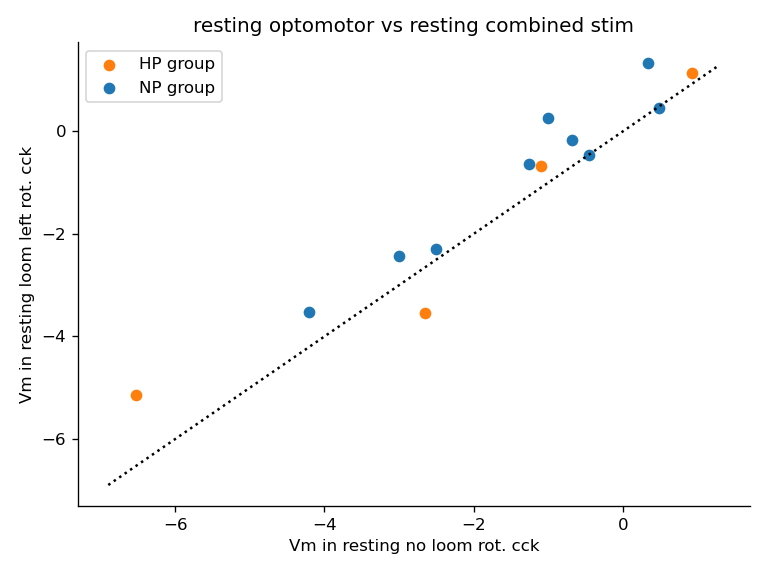

In [212]:
f,ax=plt.subplots(1,1)
ax.scatter([restingSlopeDict[fid][omot_stimID][0] for fid in sorted(hypolFlies)],
           [restingSlopeDict[fid][combi_stimID][0] for fid in sorted(hypolFlies)],
#            label=sorted(hypolFlies),
           label='HP group',
           color='tab:orange')
# ax.scatter([r[6][0] for fid,r in restingSlopeDict.items()], [r[7][0] for fid,r in restingSlopeDict.items()], label=[fid for fid,r in restingSlopeDict.items()])
ax.scatter([restingSlopeDict[fid][omot_stimID][0] for fid in sorted(nopolFlies)],
           [restingSlopeDict[fid][combi_stimID][0] for fid in sorted(nopolFlies)],
#            label=sorted(nopolFlies), 
           label='NP group',
           color='tab:blue')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_xlabel('slope factor in optomotor only stim')
# ax.set_ylabel('slope factor in optomotor with looming')
ax.set_xlabel('Vm in resting '+anlyz.get_stimulusmap(omot_stimID))
ax.set_ylabel('Vm in resting '+anlyz.get_stimulusmap(combi_stimID))
ax.legend()
# ax.plot([0,175],[0,175],':k')
# ax.plot([-5,10],[-5,10],':k')
ax.plot(ax.get_xlim(), ax.get_xlim(), 'k:')
ax.set_title('resting optomotor vs resting combined stim')
plt.tight_layout()

### plot saccade loomL+CLW vs resting CLW only

In [213]:
f,ax=plt.subplots(1,1)
# not risking anything anymore, resort to explicit sorting to be safe
ax.scatter([flyingSlopeDict[fid][omot_stimID][0] for fid in sorted(hypolFlies)],
           [saccadeSlopeDict[fid][combi_stimID][0] for fid in sorted(hypolFlies)], 
           label='HP group',
#            label=sorted(hypolFlies),
           color='tab:orange')
# ax.scatter([r[6][0] for fid,r in restingSlopeDict.items()], [r[7][0] for fid,r in restingSlopeDict.items()], label=[fid for fid,r in restingSlopeDict.items()])
ax.scatter([flyingSlopeDict[fid][omot_stimID][0] for fid in sorted(nopolFlies)],
           [saccadeSlopeDict[fid][combi_stimID][0] for fid in sorted(nopolFlies)], 
#            label=sorted(nopolFlies),
          label='NP group',
           color='tab:blue')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_xlabel('level in optomotor only')
# ax.set_ylabel('level in saccading optomotor + looming')
ax.set_xlabel('Vm in flying '+anlyz.get_stimulusmap(omot_stimID))
ax.set_ylabel('Vm in saccades '+anlyz.get_stimulusmap(combi_stimID))
ax.legend()
# ax.plot([0,16],[0,16],':k')
ax.plot(ax.get_xlim(), ax.get_xlim(), 'k:')
ax.set_title('saccade combined stim vs resting optomotor')
plt.tight_layout()

<IPython.core.display.Javascript object>

### plot how much they changed, normalized ratios

In [217]:
# consider the response to combined stim, normalized by optomotor resp
rest_hyp = [restingSlopeDict[fid][combi_stimID][0]/flyingSlopeDict[fid][omot_stimID][0]  for fid in hypolFlies]
sacc_hyp = [saccadeSlopeDict[fid][combi_stimID][0]/flyingSlopeDict[fid][omot_stimID][0]  for fid in hypolFlies]

rest_nop = [restingSlopeDict[fid][combi_stimID][0]/flyingSlopeDict[fid][omot_stimID][0]  for fid in nopolFlies]
sacc_nop = [saccadeSlopeDict[fid][combi_stimID][0]/flyingSlopeDict[fid][omot_stimID][0]  for fid in nopolFlies]


<IPython.core.display.Javascript object>


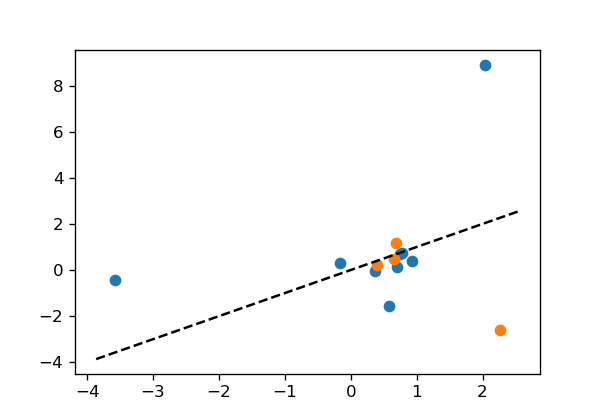

In [218]:
f,ax=plt.subplots(figsize=(5,3.5))
ax.scatter(rest_nop, sacc_nop, color='tab:blue')
ax.scatter(rest_hyp, sacc_hyp, color='tab:orange')
# ax.plot([0,2],[0,2],'k--')
ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

<IPython.core.display.Javascript object>


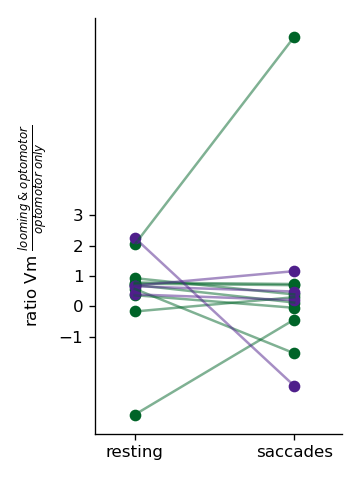

In [219]:
f,ax=plt.subplots(figsize=(3,4))

ax.plot(np.vstack((np.zeros_like(rest_nop),np.ones_like(sacc_nop))), np.vstack((rest_nop,sacc_nop)),
           '-', color=plt.cm.Greens(0.9), alpha=0.5)
#plotting markers and lines separate for easier handling of details later
ax.scatter(np.vstack((np.zeros_like(rest_nop),np.ones_like(sacc_nop))), np.vstack((rest_nop,sacc_nop)),
           color=plt.cm.Greens(0.9))
# for i in range(len(rest_nop)): #making sure
#     ax.plot([0,1],[rest_nop[i],sacc_nop[i]], 'k-o')

ax.plot(np.vstack((np.zeros_like(rest_hyp),np.ones_like(sacc_hyp))), np.vstack((rest_hyp,sacc_hyp)),
           '-', color=plt.cm.Purples(0.9), alpha=0.5)
#plotting markers and lines separate for easier handling of details later
ax.scatter(np.vstack((np.zeros_like(rest_hyp),np.ones_like(sacc_hyp))), np.vstack((rest_hyp,sacc_hyp)),
           color=plt.cm.Purples(0.9))

ax.set_xlim([-0.25,1.3])
ax.set_xticks([0,1])
ax.set_xticklabels(['resting', 'saccades'])

ax.set_ylabel('ratio Vm $\\frac{looming\; &\; optomotor}{optomotor\;only}$')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_yticks([-0.5, 0, 0.5, 1, 1.5])
ax.set_yticks([-1, 0, 1, 2,3])
plt.tight_layout()

### plot how much they changed, not-normalized

In [93]:
combi_stimID = 0
omot_stimID = 6
saFly_Lhyp.get_stimulusmap(combi_stimID), saFly_Lhyp.get_stimulusmap(omot_stimID)

('loom left rot. clw', 'no loom rot. clw')

In [94]:
print(f'combi_stimID={combi_stimID} , omot_stimID={omot_stimID}')

combi_stimID=0 , omot_stimID=6


In [95]:
# consider the response to combined stim, normalized by optomotor resp
rest_hyp = [restingSlopeDict[fid][combi_stimID][0] if combi_stimID in restingSlopeDict[fid] else np.nan for fid in hypolFlies]
sacc_hyp = [saccadeSlopeDict[fid][combi_stimID][0] if combi_stimID in saccadeSlopeDict[fid] else np.nan for fid in hypolFlies]

rest_nop = [restingSlopeDict[fid][combi_stimID][0] if combi_stimID in restingSlopeDict[fid] else np.nan for fid in nopolFlies]
sacc_nop = [saccadeSlopeDict[fid][combi_stimID][0] if combi_stimID in saccadeSlopeDict[fid] else np.nan for fid in nopolFlies]

omotFly_hyp = [flyingSlopeDict[fid][omot_stimID][0] if omot_stimID in flyingSlopeDict[fid] else np.nan for fid in hypolFlies]
omotFly_nop = [flyingSlopeDict[fid][omot_stimID][0] if omot_stimID in flyingSlopeDict[fid] else np.nan for fid in nopolFlies]
omotRest_hyp = [restingSlopeDict[fid][omot_stimID][0] if omot_stimID in restingSlopeDict[fid] else np.nan for fid in hypolFlies]
omotRest_nop = [restingSlopeDict[fid][omot_stimID][0] if omot_stimID in restingSlopeDict[fid] else np.nan for fid in nopolFlies]

In [31]:
f,ax=plt.subplots(figsize=(5,3.5))
ax.scatter(rest_nop, sacc_nop, color='tab:blue')
ax.scatter(rest_hyp, sacc_hyp, color='tab:orange')
# ax.plot([0,2],[0,2],'k--')
ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

<IPython.core.display.Javascript object>

#### more complex HP&NP in one plot

<IPython.core.display.Javascript object>


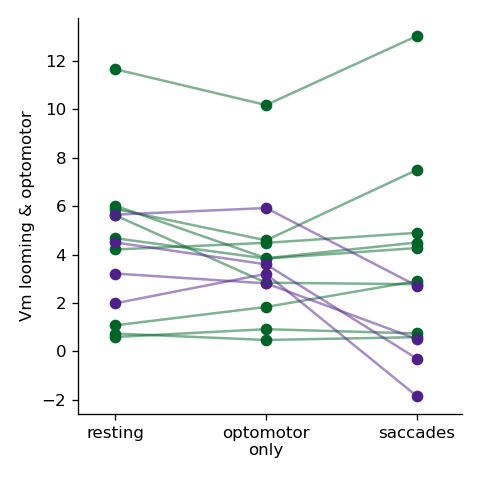

In [311]:
f,ax=plt.subplots(figsize=(4,4))

ax.plot(np.vstack((np.zeros_like(rest_nop),np.ones_like(omotFly_nop), np.full_like(sacc_nop,2.))), 
        np.vstack((rest_nop, omotFly_nop, sacc_nop)),
           '-', color=plt.cm.Greens(0.9), alpha=0.5)
#plotting markers and lines separate for easier handling of details later
ax.scatter(np.vstack((np.zeros_like(rest_nop),np.ones_like(omotFly_nop), np.full_like(sacc_nop,2.))), 
           np.vstack((rest_nop, omotFly_nop, sacc_nop)),
           color=plt.cm.Greens(0.9))

ax.plot(np.vstack((np.zeros_like(rest_hyp),np.ones_like(omotFly_hyp),np.full_like(sacc_hyp,2.))), 
        np.vstack((rest_hyp, omotFly_hyp, sacc_hyp)),
           '-', color=plt.cm.Purples(0.9), alpha=0.5)
#plotting markers and lines separate for easier handling of details later
ax.scatter(np.vstack((np.zeros_like(rest_hyp), np.ones_like(omotFly_hyp), np.full_like(sacc_hyp,2.))), 
           np.vstack((rest_hyp, omotFly_hyp, sacc_hyp)),
           color=plt.cm.Purples(0.9))

ax.set_xlim([-0.25,2.3])
ax.set_xticks([0,1,2])
ax.set_xticklabels(['resting', 'optomotor\nonly', 'saccades'])

ax.set_ylabel('Vm looming & optomotor')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_yticks([-0.5, 0, 0.5, 1, 1.5])
# ax.set_yticks([-1, 0, 1, 2,3])
plt.tight_layout()

In [312]:
f.savefig(os.path.join(DATAPATH, 'Figures4Paper','slopeInhibition_quantified',
                      'slopeInhibition_loomLrotCLW_VmLevel_rest-sacc-opmot-trajectoryPlot.png'))
#                       'slopeInhibition_loomLrotCCK_VmLevel_rest-sacc-opmot-trajectoryPlot.png'))
#                       'slopeInhibition_loomRrotCLW_VmLevel_rest-sacc-opmot-trajectoryPlot.png'))
#                       'slopeInhibition_loomRrotCCK_VmLevel_rest-sacc-trajectorycPlot.png'))
f.savefig(os.path.join(DATAPATH, 'Figures4Paper','slopeInhibition_quantified',
                      'slopeInhibition_loomLrotCLW_VmLevel_rest-sacc-opmot-trajectoryPlot.svg'))
#                       'slopeInhibition_loomLrotCCK_VmLevel_rest-sacc-opmot-trajectoryPlot.svg'))
#                       'slopeInhibition_loomRrotCLW_VmLevel_rest-sacc-opmot-trajectoryPlot.svg'))
#                       'slopeInhibition_loomRrotCCK_VmLevel_rest-sacc-opmot-trajectoryPlot.svg'))

<IPython.core.display.Javascript object>


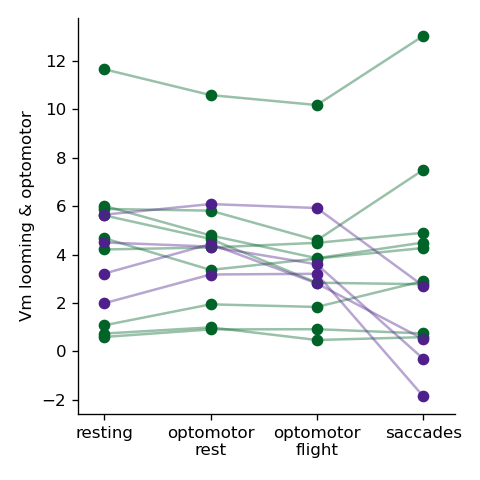

In [313]:
f,ax=plt.subplots(figsize=(4,4))

ax.plot(np.vstack((np.zeros_like(rest_nop),np.ones_like(omotRest_nop), np.full_like(omotFly_nop,2.), np.full_like(sacc_nop,3.))), 
        np.vstack((rest_nop,omotRest_nop, omotFly_nop, sacc_nop)),
           '-', color=plt.cm.Greens(0.9), alpha=0.4)
#plotting markers and lines separate for easier handling of details later
ax.scatter(np.vstack((np.zeros_like(rest_nop), np.ones_like(omotRest_nop), np.full_like(omotFly_nop,2.), np.full_like(sacc_nop,3.))), 
           np.vstack((rest_nop, omotRest_nop, omotFly_nop, sacc_nop)),
           color=plt.cm.Greens(0.9))

ax.plot(np.vstack((np.zeros_like(rest_hyp),np.ones_like(omotRest_hyp), np.full_like(omotFly_hyp,2) ,np.full_like(sacc_hyp,3.))), 
        np.vstack((rest_hyp, omotRest_hyp, omotFly_hyp, sacc_hyp)),
           '-', color=plt.cm.Purples(0.9), alpha=0.4)
#plotting markers and lines separate for easier handling of details later
ax.scatter(np.vstack((np.zeros_like(rest_hyp), np.ones_like(omotRest_hyp),np.full_like(omotFly_hyp,2.), np.full_like(sacc_hyp,3.))), 
           np.vstack((rest_hyp, omotRest_hyp, omotFly_hyp, sacc_hyp)),
           color=plt.cm.Purples(0.9))

ax.set_xlim([-0.25,3.3])
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['resting', 'optomotor\nrest', 'optomotor\nflight', 'saccades'])

ax.set_ylabel('Vm looming & optomotor')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_yticks([-0.4, 0, 0.4, 1, 1.5])
# ax.set_yticks([-1, 0, 1, 2,3])
plt.tight_layout()

In [314]:
f.savefig(os.path.join(DATAPATH, 'Figures4Paper','slopeInhibition_quantified',
                      'slopeInhibition_loomLrotCLW_VmLevel_rest-sacc-bothOpmot-trajectoryPlot.png'))
#                       'slopeInhibition_loomLrotCCK_VmLevel_rest-sacc-bothOpmot-trajectoryPlot.png'))
#                       'slopeInhibition_loomRrotCLW_VmLevel_rest-sacc-bothOpmot-trajectoryPlot.png'))
#                       'slopeInhibition_loomRrotCCK_VmLevel_rest-sacc-trajectorycPlot.png'))
f.savefig(os.path.join(DATAPATH, 'Figures4Paper','slopeInhibition_quantified',
                      'slopeInhibition_loomLrotCLW_VmLevel_rest-sacc-bothOpmot-trajectoryPlot.svg'))
#                       'slopeInhibition_loomLrotCCK_VmLevel_rest-sacc-bothOpmot-trajectoryPlot.svg'))
#                       'slopeInhibition_loomRrotCLW_VmLevel_rest-sacc-bothOpmot-trajectoryPlot.svg'))
#                       'slopeInhibition_loomRrotCCK_VmLevel_rest-sacc-bothOpmot-trajectoryPlot.svg'))

#### simpler plots for HP and NP separately
This way we can also apply the same colorscheme as in the panels Fig4 A-D

In [32]:
print(f'combi_stimID={combi_stimID} , omot_stimID={omot_stimID}')

combi_stimID=3 , omot_stimID=6


<IPython.core.display.Javascript object>


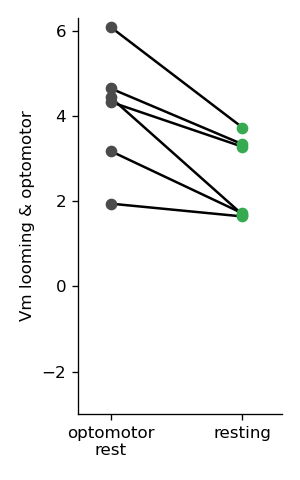

ShapiroResult(statistic=0.9632501602172852, pvalue=0.8444058895111084)
Ttest_relResult(statistic=4.230260306245926, pvalue=0.008246207355891327)
WilcoxonResult(statistic=0.0, pvalue=0.03125)


In [43]:
# plot for NP/HP spont group

f,ax=plt.subplots(figsize=(2.5,4))

#plotting markers and lines separate for easier handling of details later
ax.plot(np.vstack((np.zeros_like(omotRest_hyp), np.ones_like(rest_hyp))), 
        np.vstack((omotRest_hyp, rest_hyp)),
           #'-', color=plt.cm.Greens(0.9), alpha=0.4)
        '-',color='k', zorder=0)

ax.scatter(np.zeros_like(omotRest_hyp), omotRest_hyp, marker='o', color=np.array([75,75,75])/255)
ax.scatter(np.ones_like(rest_hyp), rest_hyp, marker='o', color=(54/255, 170/255, 80/255))

ax.set_xlim([-0.25,1.3])
ax.set_xticks([0,1])
ax.set_xticklabels(['optomotor\nrest','resting'])

ax.set_ylabel('Vm looming & optomotor')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_yticks([-0.4, 0, 0.4, 1, 1.5])
# ax.set_yticks([-1, 0, 1, 2,3])
ax.set_ylim([-3, 6.3])
plt.tight_layout()

print(stats.shapiro(np.array(omotRest_hyp)-np.array(rest_hyp)))
print(stats.ttest_rel(omotRest_hyp, rest_hyp))
print(stats.wilcoxon(omotRest_hyp, rest_hyp))

In [44]:
f.savefig(os.path.join(DATAPATH, 'Figures4Paper','slopeInhibition_quantified',
#                       'slopeInhibition_loomRrotCLW_VmLevel_opmot-rest-trajectoryPlot_NPspont_v2.png'))
                      'slopeInhibition_loomRrotCLW_VmLevel_opmot-rest-trajectoryPlot_HPspont_v2.png'))
f.savefig(os.path.join(DATAPATH, 'Figures4Paper','slopeInhibition_quantified',
#                       'slopeInhibition_loomRrotCLW_VmLevel_opmot-rest-trajectoryPlot_NPspont_v2.svg'))
                      'slopeInhibition_loomRrotCLW_VmLevel_opmot-rest-trajectoryPlot_HPspont_v2.svg'))

<IPython.core.display.Javascript object>


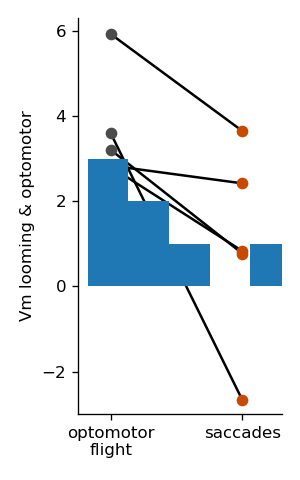

ShapiroResult(statistic=nan, pvalue=1.0)
Ttest_relResult(statistic=nan, pvalue=nan)
WilcoxonResult(statistic=0.0, pvalue=0.4375)


In [45]:
# plot for NP/HP group , optomotor and saccades

f,ax=plt.subplots(figsize=(2.5,4))

#plotting markers and lines separate for easier handling of details later
ax.plot(np.vstack((np.zeros_like(omotFly_hyp), np.ones_like(sacc_hyp))), 
        np.vstack((omotFly_hyp, sacc_hyp)),
           #'-', color=plt.cm.Greens(0.9), alpha=0.4)
        '-',color='k', zorder=0)

ax.scatter(np.zeros_like(omotFly_hyp), omotFly_hyp, marker='o', color=np.array([75,75,75])/255)
ax.scatter(np.ones_like(sacc_hyp), sacc_hyp, marker='o', color=(200/255, 74/255, 0/255))

ax.set_xlim([-0.25,1.3])
ax.set_xticks([0,1])
ax.set_xticklabels(['optomotor\nflight','saccades'])

ax.set_ylabel('Vm looming & optomotor')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_yticks([-0.4, 0, 0.4, 1, 1.5])
# ax.set_yticks([-1, 0, 1, 2,3])
ax.set_ylim([-3, 6.3])
plt.tight_layout()

print(stats.shapiro(np.array(omotFly_hyp)-np.array(sacc_hyp)))
print(stats.ttest_rel(omotFly_hyp, sacc_hyp))
print(stats.wilcoxon(omotFly_hyp, sacc_hyp))

<IPython.core.display.Javascript object>


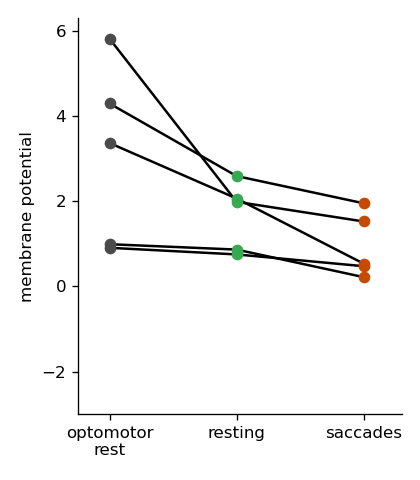

In [63]:
#plot for HPspont group 

f,ax=plt.subplots(figsize=(3.5,4))

#plotting markers and lines separate for easier handling of details later
ax.plot(np.vstack((np.zeros_like(omotRest_nop), np.ones_like(rest_nop), np.full_like(sacc_nop, 2))), 
        np.vstack((omotRest_nop, rest_nop, sacc_nop)),
           #'-', color=plt.cm.Greens(0.9), alpha=0.4)
        '-',color='k', zorder=0)

ax.scatter(np.zeros_like(omotRest_nop), omotRest_nop, marker='o', color=np.array([75,75,75])/255)
ax.scatter(np.ones_like(rest_nop), rest_nop, marker='o', color=(54/255, 170/255, 80/255))
ax.scatter(np.full_like(sacc_nop,2), sacc_nop, marker='o', color=(200/255, 74/255, 0/255))

ax.set_xlim([-0.25,2.3])
ax.set_xticks([0,1,2])
ax.set_xticklabels(['optomotor\nrest','resting','saccades'])

ax.set_ylabel('membrane potential')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_yticks([-0.4, 0, 0.4, 1, 1.5])
# ax.set_yticks([-1, 0, 1, 2,3])
ax.set_ylim([-3, 6.3])
plt.tight_layout()

In [135]:
print(stats.shapiro(np.array(omotRest_hyp)-np.array(rest_hyp)))
print(stats.ttest_rel(omotRest_hyp, rest_hyp))
print(stats.shapiro(np.array(sacc_hyp)-np.array(rest_hyp)))
print(stats.wilcoxon(rest_hyp, sacc_hyp))

ShapiroResult(statistic=0.8968878984451294, pvalue=0.39292487502098083)
Ttest_relResult(statistic=5.473243666602155, pvalue=0.005422679311162783)
ShapiroResult(statistic=0.6815470457077026, pvalue=0.006079163867980242)
WilcoxonResult(statistic=0.0, pvalue=0.0625)


## statistical test on ratio

In [96]:
print(f'omot_stimID={omot_stimID} , combi_stimID={combi_stimID}')

omot_stimID=6 , combi_stimID=0


In [239]:
# test if populations HPcontra and NPcontra are different during saccade (and were they different during rest to boot)
stats.mannwhitneyu(sacc_nop, sacc_hyp, method='exact'), stats.mannwhitneyu(rest_nop, rest_hyp, method='exact')

(MannwhitneyuResult(statistic=34.0, pvalue=0.011188811188811189),
 MannwhitneyuResult(statistic=20.0, pvalue=0.8251748251748252))

In [240]:
# are the populations (distr. of responses) significantly different rest from saccades for HP and NP
stats.mannwhitneyu(rest_hyp, sacc_hyp, method='exact'), stats.mannwhitneyu(rest_nop, sacc_nop, method='exact')

(MannwhitneyuResult(statistic=15.0, pvalue=0.05714285714285714),
 MannwhitneyuResult(statistic=43.0, pvalue=0.8633072809543397))

## statistical test on absolute value

In [115]:
combi_stimID = 3
omot_stimID = 6
saSacc_Lhyp.get_stimulusmap(combi_stimID), saSacc_Lhyp.get_stimulusmap(omot_stimID)

('loom right rot. clw', 'no loom rot. clw')

In [116]:
print(f'combi_stimID={combi_stimID} , omot_stimID={omot_stimID}')

combi_stimID=3 , omot_stimID=6


In [117]:
# consider the response to combined stim, normalized by optomotor resp
rest_hyp = [restingSlopeDict[fid][combi_stimID][0] if combi_stimID in restingSlopeDict[fid] for fid in hypolFlies]
sacc_hyp = [saccadeSlopeDict[fid][combi_stimID][0] if combi_stimID in saccadeSlopeDict[fid] for fid in hypolFlies]

rest_nop = [restingSlopeDict[fid][combi_stimID][0] if combi_stimID in restingSlopeDict[fid] else np.nan for fid in nopolFlies]
sacc_nop = [saccadeSlopeDict[fid][combi_stimID][0] if combi_stimID in saccadeSlopeDict[fid] else np.nan for fid in nopolFlies]

omotFly_hyp = [flyingSlopeDict[fid][omot_stimID][0] if omot_stimID in flyingSlopeDict[fid] else np.nan for fid in hypolFlies]
omotFly_nop = [flyingSlopeDict[fid][omot_stimID][0] if omot_stimID in flyingSlopeDict[fid] else np.nan for fid in nopolFlies]
omotRest_hyp = [restingSlopeDict[fid][omot_stimID][0] if omot_stimID in restingSlopeDict[fid] else np.nan for fid in hypolFlies]
omotRest_nop = [restingSlopeDict[fid][omot_stimID][0] if omot_stimID in restingSlopeDict[fid] else np.nan for fid in nopolFlies]

In [118]:
# test if populations HPcontra and NPcontra are different during saccade (and were they different during rest to boot)
print('test responses HP vs NP groups')
print(f"in saccade trials: {stats.mannwhitneyu(sacc_nop, sacc_hyp, method='exact')},\n"
      f"in resting trials: {stats.mannwhitneyu(rest_nop, rest_hyp, method='exact')}\n"
      f"in optomotor only: {stats.mannwhitneyu(omotFly_nop, omotFly_hyp, method='exact')}")

test responses HP vs NP groups
in saccade trials: MannwhitneyuResult(statistic=9.0, pvalue=0.5476190476190477),
in resting trials: MannwhitneyuResult(statistic=6.0, pvalue=0.2222222222222222)
in optomotor only: MannwhitneyuResult(statistic=12.0, pvalue=1.0)


NB: Wilcoxon test computes the differences \$d_i = x_i - y_i \$.
The two-sided test has the null hypothesis that the median of the differences is zero against the alternative that it is different from zero. The one-sided test has the null hypothesis that the median is positive (i.e. \$y<x\$ as \$H_0\$) against the alternative that it is negative (alternative == 'less'), or vice versa (alternative == 'greater.', i.e. \$y>x\$).

Thus, if we expect y to be larger than x, set alternative == 'less')  [calling wilcoxon(x,y,...)]

In [124]:
# are the populations (distr. of responses) significantly different rest from saccades for HP and NP
# <- useful for the type of plot with only two columns, now I do it differently (compare to optomotor only)
print('test rest vs saccades within groups')
print(f"HP group: {stats.wilcoxon(sacc_hyp,rest_hyp, alternative='less', mode='exact')},",
      f"\nNP group: {stats.wilcoxon(sacc_nop,rest_nop, alternative='less', mode='exact')}")

test rest vs saccades within groups
HP group: WilcoxonResult(statistic=0.0, pvalue=0.03125), 
NP group: WilcoxonResult(statistic=0.0, pvalue=0.03125)


In [136]:
# are the pop. (distr of response) signif. diff. combined resting vs optomotor only
print('test rest combi vs omot only (within groups)')
print(f"HP group: {stats.wilcoxon(rest_hyp, omotRest_hyp, alternative='less', mode='exact')},\n"
     f"NP group: {stats.wilcoxon(rest_nop, omotRest_nop, alternative='less', mode='exact')}")

test rest combi vs omot only (within groups)
HP group: WilcoxonResult(statistic=0.0, pvalue=0.03125),
NP group: WilcoxonResult(statistic=0.0, pvalue=0.03125)


In [294]:
# are the pop. (distr of response) signif. diff. combined SACCADES vs OPTOMOTOR
# MORE RELEVANT THAN RESTING above
print('test rest combi vs omot only (within groups)')
print(f"HP group: {stats.wilcoxon(sacc_hyp, omotFly_hyp, alternative='less', mode='exact')},\n"
     f"NP groups: {stats.wilcoxon(sacc_nop, omotFly_nop, alternative='less', mode='exact')}")
# print(f"HP group: {stats.wilcoxon(sacc_hyp, omotFly_hyp, alternative='two-sided', mode='exact')},\n" #for CCK rotation
#      f"NP groups: {stats.wilcoxon(sacc_nop, omotFly_nop, alternative='two-sided', mode='exact')}")

test rest combi vs omot only (within groups)
HP group: WilcoxonResult(statistic=0.0, pvalue=0.03125),
NP groups: WilcoxonResult(statistic=0.0, pvalue=0.03125)


In [291]:
# especially for IPSILATERAL LOOMING
# stats.wilcoxon([*sacc_hyp, *sacc_nop], [*omotFly_hyp,*omotFly_nop], mode='exact'),\
stats.wilcoxon([*rest_hyp, *rest_nop], [*omotRest_hyp,*omotRest_nop], mode='exact'),\
# stats.wilcoxon([*sacc_hyp, *sacc_nop], [*rest_hyp, *rest_nop], mode='exact')

(WilcoxonResult(statistic=0.0, pvalue=0.001953125),)

In [292]:
# especially for IPSILATERAL LOOMING
# stats.wilcoxon([*sacc_hyp, *sacc_nop], [*omotFly_hyp,*omotFly_nop], mode='exact'),\
stats.mannwhitneyu([*rest_hyp, *rest_nop], [*omotRest_hyp,*omotRest_nop], alternative='two-sided', method='exact'),\
# stats.wilcoxon([*sacc_hyp, *sacc_nop], [*rest_hyp, *rest_nop], mode='exact')

(MannwhitneyuResult(statistic=20.0, pvalue=0.023230639329710537),)

### same with t-tests

In [127]:
# combi_stimID = 1
# omot_stimID = 7
print( saSacc_Lhyp.get_stimulusmap(combi_stimID), saSacc_Lhyp.get_stimulusmap(omot_stimID))
print(f'combi_stimID={combi_stimID} , omot_stimID={omot_stimID}')

loom right rot. clw no loom rot. clw
combi_stimID=3 , omot_stimID=6


In [297]:
# test if populations HPcontra and NPcontra are different during saccade (and were they different during rest to boot)
print('Shapiro-Wilks-test for gaussianness')
print(f"in saccade trials: {stats.shapiro(np.array(sacc_nop))}, \n\t\t{stats.shapiro(np.array(sacc_hyp))},\n"
      f"in resting trials: {stats.shapiro(np.array(rest_nop))}, \n\t\t{stats.shapiro(np.array(rest_hyp))}\n"
      f"in optomotor only: {stats.shapiro(np.array(omotFly_nop))}, \n\t\t{stats.shapiro(np.array(omotFly_hyp))}\n")
print('test responses HP vs NP groups')
print(f"in saccade trials: {stats.ttest_ind(sacc_nop, sacc_hyp)},\n"
      f"in resting trials: {stats.ttest_ind(rest_nop, rest_hyp)}\n"
      f"in optomotor only: {stats.ttest_ind(omotFly_nop, omotFly_hyp)}")

Shapiro-Wilks-test for gaussianness
in saccade trials: ShapiroResult(statistic=0.8713482618331909, pvalue=0.27192631363868713), 
		ShapiroResult(statistic=0.9358937740325928, pvalue=0.6370723247528076),
in resting trials: ShapiroResult(statistic=0.8814549446105957, pvalue=0.315956175327301), 
		ShapiroResult(statistic=0.8083728551864624, pvalue=0.09465516358613968)
in optomotor only: ShapiroResult(statistic=0.8059902191162109, pvalue=0.09059374779462814), 
		ShapiroResult(statistic=0.7536044120788574, pvalue=0.032129645347595215)

test responses HP vs NP groups
in saccade trials: Ttest_indResult(statistic=-0.051775704983615535, pvalue=0.9599768871795422),
in resting trials: Ttest_indResult(statistic=-1.945270831416, pvalue=0.08763006072771148)
in optomotor only: Ttest_indResult(statistic=-0.763935538972814, pvalue=0.4668365318557607)


In [135]:
# are the populations (distr. of responses) significantly different rest from saccades for HP and NP
print('test rest vs saccades within groups')
print(f'HP group normality test: {stats.shapiro(np.array(rest_hyp)-np.array(sacc_hyp))},\n')
#       f'NP group normality test: {stats.shapiro(np.array(rest_nop)-np.array(sacc_nop))}')
print(f"HP group: {stats.ttest_rel(rest_hyp, sacc_hyp, alternative='greater')},",)
#       f"\nNP group: {stats.ttest_rel(rest_nop, sacc_nop, alternative='greater')}")

test rest vs saccades within groups
HP group normality test: ShapiroResult(statistic=0.6815470457077026, pvalue=0.006079163867980242),

HP group: Ttest_relResult(statistic=1.6493033439537919, pvalue=0.08721527263336022),


In [141]:
# are the pop. (distr of response) signif. diff. combined resting vs optomotor only
print('test rest combi vs omot only (within groups)')
print(f'HP group normality test: {stats.shapiro(np.array(rest_hyp)-np.array(omotRest_hyp))},\n'
      f'NP group normality test: {stats.shapiro(np.array(rest_nop)-np.array(omotRest_nop))}')
print(f"HP group: {stats.ttest_rel(rest_hyp, omotRest_hyp, alternative='less')},\n"
     f"NP groups: {stats.ttest_rel(rest_nop, omotRest_nop, alternative='less')}")

test rest combi vs omot only (within groups)
HP group normality test: ShapiroResult(statistic=0.896888017654419, pvalue=0.392925500869751),
NP group normality test: ShapiroResult(statistic=0.8762285113334656, pvalue=0.29256850481033325)
HP group: Ttest_relResult(statistic=-5.473243666602155, pvalue=0.0027113396555813914),
NP groups: Ttest_relResult(statistic=-2.101816603901617, pvalue=0.05172048360185302)


In [107]:
# are the pop. (distr of response) signif. diff. combined saccades vs optomotor only
print('test rest combi vs omot only (within groups)')
print(f'HP group normality test: {stats.shapiro(np.array(sacc_hyp)-np.array(omotFly_hyp))},\n'
      f'NP group normality test: {stats.shapiro(np.array(sacc_nop)-np.array(omotFly_nop))}')
print(f"HP group: {stats.ttest_rel(sacc_hyp, omotFly_hyp, alternative='less')},\n" #for CLW rot.
     f"NP group: {stats.ttest_rel(sacc_nop, omotFly_nop, alternative='less')}")
# print(f"HP group: {stats.ttest_rel(sacc_hyp, omotFly_hyp, alternative='two-sided')},\n" #for CCK rot.
#      f"NP group: {stats.ttest_rel(sacc_nop, omotFly_nop, alternative='two-sided')}")

test rest combi vs omot only (within groups)
HP group normality test: ShapiroResult(statistic=0.9962811470031738, pvalue=0.9869317412376404),
NP group normality test: ShapiroResult(statistic=0.7967464327812195, pvalue=0.01874570921063423)
HP group: Ttest_relResult(statistic=-6.228320397801982, pvalue=0.004172765259130573),
NP group: Ttest_relResult(statistic=2.3269160560325095, pvalue=0.9758029443248973)


In [298]:
# especiall for IPSILATERAL LOOMING
# stats.wilcoxon([*sacc_hyp, *sacc_nop], [*omotFly_hyp,*omotFly_nop], mode='exact'),\
print(stats.shapiro(np.array([*rest_hyp, *rest_nop]) - np.array([*omotRest_hyp,*omotRest_nop])))
stats.ttest_rel([*rest_hyp, *rest_nop], [*omotRest_hyp,*omotRest_nop]),\
# stats.wilcoxon([*sacc_hyp, *sacc_nop], [*rest_hyp, *rest_nop], mode='exact')

ShapiroResult(statistic=0.9440183639526367, pvalue=0.5985285043716431)


(Ttest_relResult(statistic=-4.46366152999181, pvalue=0.0015689438169307608),)

## statistical test on difference

In [91]:
before_hyp = [restingSlopeDict[fid][combi_stimID][0]-restingSlopeDict[fid][omot_stimID][0]  for fid in hypolFlies]
after_hyp =  [saccadeSlopeDict[fid][combi_stimID][0]-restingSlopeDict[fid][omot_stimID][0]  for fid in hypolFlies]

before_nop = [restingSlopeDict[fid][combi_stimID][0]-restingSlopeDict[fid][omot_stimID][0]  for fid in nopolFlies]
after_nop =  [saccadeSlopeDict[fid][combi_stimID][0]-restingSlopeDict[fid][omot_stimID][0]  for fid in nopolFlies]


In [92]:
stats.mannwhitneyu(after_nop, after_hyp, method='exact'), stats.mannwhitneyu(before_nop, before_hyp, method='exact') #!? ->need a plot to look at this

(MannwhitneyuResult(statistic=36.0, pvalue=0.002797202797202797),
 MannwhitneyuResult(statistic=36.0, pvalue=0.002797202797202797))

## plot combined vs optomotor only in all flies together

In [213]:
hypolFlies = sorted([v.lower() for _,v in saSacc_Rhyp.flyID.items()])
nopolFlies = sorted([v.lower() for _,v in saSacc_Rnop.flyID.items()])

<IPython.core.display.Javascript object>


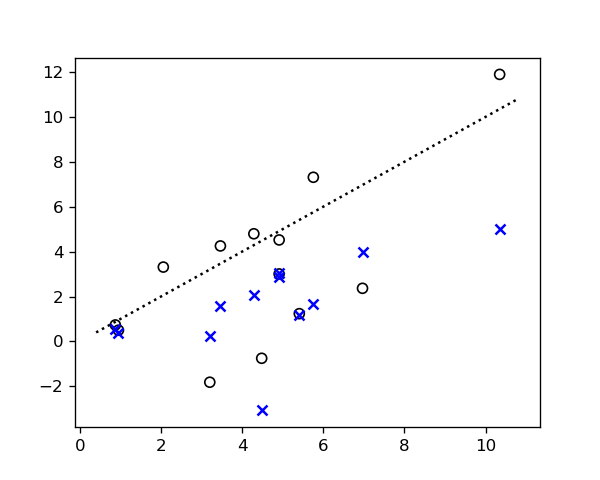

In [214]:
f,ax=plt.subplots(figsize=(5,4))
flylist = sorted(restingSlopeDict.keys())
ax.scatter([restingSlopeDict[fid][6][0] for fid in flylist],
           [saccadeSlopeDict[fid][0][0] for fid in flylist],
           marker='o',facecolor='none', color='k')
ax.scatter([restingSlopeDict[fid][6][0] for fid in flylist],
           [saccadeSlopeDict[fid][3][0] for fid in flylist],
           marker='x',facecolor='b', edgecolor='k')
ax.plot(ax.get_xlim(), ax.get_xlim(), 'k:')

<IPython.core.display.Javascript object>


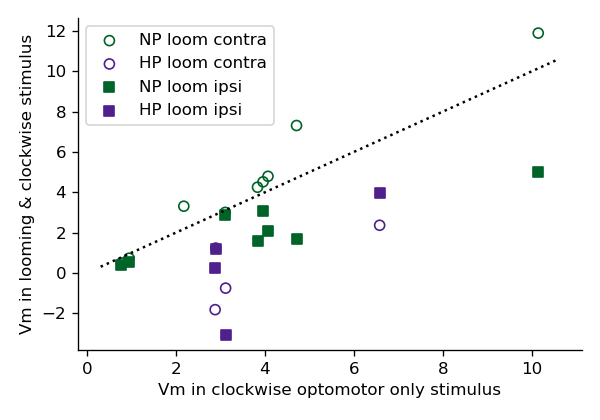

In [216]:
f,ax=plt.subplots(figsize=(5,3.5))
# flylist = sorted(sqaccadeSlopeDict.keys())

ax.scatter([flyingSlopeDict[fid][6][0] for fid in nopolFlies],
           [saccadeSlopeDict[fid][0][0] for fid in nopolFlies],
           marker='o',facecolor='none', label='NP loom contra',
           edgecolor=plt.cm.Greens(0.9))
ax.scatter([flyingSlopeDict[fid][6][0] for fid in hypolFlies],
           [saccadeSlopeDict[fid][0][0] for fid in hypolFlies],
           marker='o',facecolor='none', label='HP loom contra',
           edgecolor=plt.cm.Purples(0.9))

ax.scatter([flyingSlopeDict[fid][6][0] for fid in nopolFlies],
           [saccadeSlopeDict[fid][3][0] for fid in nopolFlies],
           marker='s', label='NP loom ipsi',
           facecolor=plt.cm.Greens(0.9))
ax.scatter([flyingSlopeDict[fid][6][0] for fid in hypolFlies],
           [saccadeSlopeDict[fid][3][0] for fid in hypolFlies],
           marker='s', label='HP loom ipsi',
           facecolor=plt.cm.Purples(0.9))

# ax.scatter([flyingSlopeDict[fid][6][0] for fid in flylist],
#            [saccadeSlopeDict[fid][3][0] for fid in flylist],
#            marker='x',facecolor='b', edgecolor='k')
ax.plot(ax.get_xlim(), ax.get_xlim(), 'k:')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Vm in clockwise optomotor only stimulus')
# ax.set_ylabel('ratio Vm $\\frac{looming\; &\; Clockwise}{optomotor\;only}$')
ax.set_ylabel('Vm in looming & clockwise stimulus')
ax.legend()
plt.tight_layout()

<IPython.core.display.Javascript object>


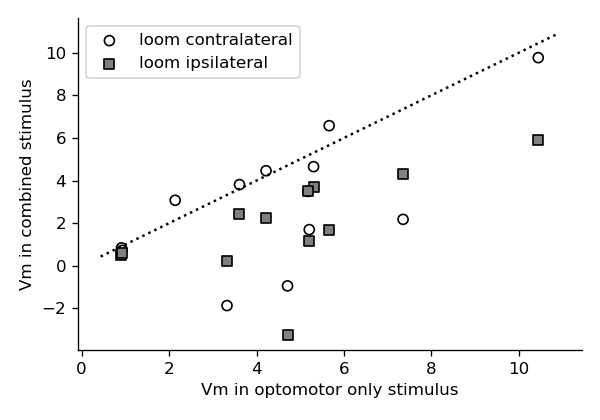

In [263]:
f,ax=plt.subplots(figsize=(5,3.5))
flylist = sorted(saccadeSlopeDict.keys())

ax.scatter([restingSlopeDict[fid][6][0] for fid in flylist],
           [saccadeSlopeDict[fid][0][0] for fid in flylist],
           marker='o',facecolor='none', edgecolor='k', label='loom contralateral')

ax.scatter([restingSlopeDict[fid][6][0] for fid in flylist],
           [saccadeSlopeDict[fid][3][0] for fid in flylist],
           marker='s',facecolor='gray', edgecolor='k', label='loom ipsilateral')

# ax.plot(ax.get_xlim(), ax.get_xlim(), 'k:', label='y=x')
ax.plot(ax.get_xlim(), ax.get_xlim(), 'k:')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Vm in optomotor only stimulus')
ax.set_ylabel('Vm in combined stimulus')
ax.legend()
plt.tight_layout()

<IPython.core.display.Javascript object>


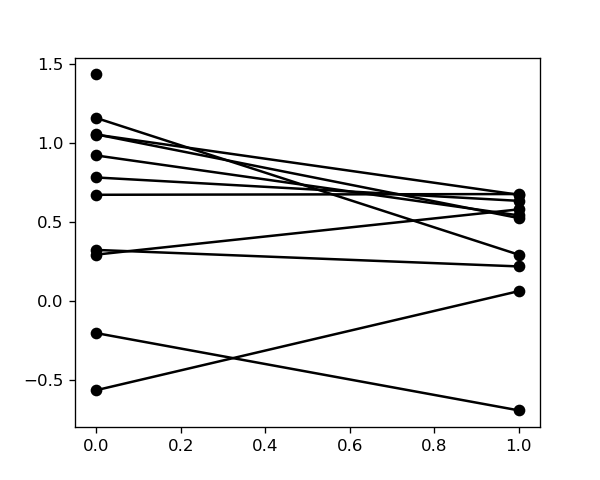

In [229]:
flylist = sorted(sacc_loomR.keys())
loomL = [sacc_loomL[fid][0][0]/rest_loomR[fid][6][0] for fid in flylist]
loomR = [sacc_loomR[fid][3][0]/rest_loomR[fid][6][0] for fid in flylist]

f,ax=plt.subplots(figsize=(5,4))
ax.scatter(np.vstack((np.zeros_like(loomL), np.ones_like(loomR))), np.vstack((loomL,loomR)), color='k')
ax.plot(np.vstack((np.zeros_like(loomL), np.ones_like(loomR))), np.vstack((loomL,loomR)), color='k')

# simple Vm plots of hyperpolarization saccades Y/N
Need to either calculate using method above or load the pickled results. But first make sure that this method is valid, in the sense that it measures the Vm in the correct time window.

## analyze straight
Whether we form the saSacc/Rest_all from the spont or contra groups does not matter, since all we want to do is analyze all of them and store in a dict for each fly separately

In [13]:
saStrg_all = copy.deepcopy(saStrg_Rhyp)
saStrg_all+saStrg_Rnop

C:\Users\Phil\Documents\notebooks\baseClasses.py:256: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  selector = allValues.between(start-0.05, start+tolerance, inclusive=True)#inclusive=True is default


In [75]:
anlyz = saStrg_all
allfliesBAK = copy.deepcopy(anlyz)

In [76]:
# trial-wise version

slopeDict = {}
toPlot = False

for flyNo, flyid in list(allfliesBAK.flyID.items()):
    print(flyNo)
    print('\n\t',flyid)
    thisFly = copy.copy(allfliesBAK)
    thisFly.remove_duds_byList(np.nonzero(thisFly.fly_indices!=flyNo))
    thisFly.average_by_stimSignal()

    # iterate through stims for which to calculate
    results = {}
    for stimID in set(thisFly.group_indices):
        d = thisFly.get_by_group(stimID)
        results[stimID] = np.zeros((d.shape[0],3))
        for i in range(d.shape[0]):
            # average level
            start = int((anlyz.preStim+ anlyz.meanFramePeriod*(anlyz.stimulusPhases_inframes[1]+sample_endLoom))*anlyz.samplingRate)
            stop = int((anlyz.preStim+ anlyz.meanFramePeriod*(anlyz.stimulusPhases_inframes[1]+sample_optomotor))*anlyz.samplingRate)
            meanAmpl = np.mean(100.*d[i,0, stop-80:stop+80])
            startVal = np.mean(100.*d[i,0, start-0:start+int(avgWindow_endLoom*anlyz.samplingRate)])
            before = np.mean(100.*d[i,0, start-int(0.2*anlyz.samplingRate):start])
            results[stimID][i] = [meanAmpl, startVal, before]
        
            #just look for minima
#             start = int((anlyz.preStim+ anlyz.meanFramePeriod*anlyz.stimulusPhases_inframes[1])*anlyz.samplingRate)
#             stop = int((anlyz.preStim+ anlyz.meanFramePeriod*anlyz.stimulusPhases_inframes[1]+0.14)*anlyz.samplingRate)
#             sig = ndimage.gaussian_filter1d(d[i,0]*100., 60)
#             idx = np.argmin(sig[start:stop])+start
#             before = np.mean(100.*d[i,0, start-int(0.2*anlyz.samplingRate):start])
#             results[stimID][i] = [idx, np.mean([sig[idx-100:idx+150]]), before]

    if toPlot:
        f,ax=plt.subplots(1,1, figsize=(4.5,3))
        try:
            ax.plot(100.*d[2])
            ax.plot(100.*ndimage.gaussian_filter1d(d[2],100))
#         ax.plot(100.*d[6])
            ax.axvline(start, color='k')
            ax.axvline(stop, color='k')
            # average level
            ax.axhline(results[2][1], color='tab:blue')
#         ax.axhline(results[6], color='tab:orange')
            ax.legend([results[2][1]])
        except KeyError:
            pass
    slopeDict[flyid.lower()] = results
# print('\n',slopeDict)

0

	 fly1_WTCS_20180725_cell1
1

	 fly4_X21_20200420_cell1
2

	 fly1_u29xg06_20190213_cell1
3

	 fly1_WTCS_20190726_cell1
4

	 fly3_U29xG16_20200129_cell1
5

	 fly1_X20a_20200316_cell1
6

	 fly1_G06xU29_20191104_cell1
7

	 fly1_U29xG16_20191209_cell2
8

	 fly3_X21_20200415_cell1
9

	 fly3_x21_20200417_cell1
10

	 fly2_X20_20210217_cell1
11

	 fly1_WTCS_20191106_cell1
12

	 fly1_U29xG16_20200129_cell1


In [77]:
straightSlopeDict = slopeDict

In [78]:
plt.close('all')

## analyze saccades

In [18]:
saSacc_all = copy.deepcopy(saSacc_Rhyp)
saSacc_all+saSacc_Rnop

In [80]:
anlyz = saSacc_all
allfliesBAK = copy.deepcopy(anlyz)

In [81]:
# trial-wise version

slopeDict = {}
toPlot = False

for flyNo, flyid in list(allfliesBAK.flyID.items()):
    print(flyNo)
#     if flyNo>1: break
    print('\n\t',flyid)
    thisFly = copy.copy(allfliesBAK)
    thisFly.remove_duds_byList(np.nonzero(thisFly.fly_indices!=flyNo))
    thisFly.average_by_stimSignal()

    # iterate through stims for which to calculate
    results = {}
    for stimID in set(thisFly.group_indices):
        d = thisFly.get_by_group(stimID)
        results[stimID] = np.zeros((d.shape[0],3))
        for i in range(d.shape[0]):
            # average level
            start = int((anlyz.preStim+ anlyz.meanFramePeriod*(anlyz.stimulusPhases_inframes[1]+sample_endLoom))*anlyz.samplingRate)
            stop = int((anlyz.preStim+ anlyz.meanFramePeriod*(anlyz.stimulusPhases_inframes[1]+sample_optomotor))*anlyz.samplingRate)
            meanAmpl = np.mean(100.*d[i,0, stop-80:stop+80])
            startVal = np.mean(100.*d[i,0, start-0:start+int(avgWindow_endLoom*anlyz.samplingRate)])
            before = np.mean(100.*d[i,0, start-int(0.2*anlyz.samplingRate):start])
            results[stimID][i] = [meanAmpl, startVal, before]
        
            #just look for minima
#             start = int((anlyz.preStim+ anlyz.meanFramePeriod*anlyz.stimulusPhases_inframes[1])*anlyz.samplingRate)
#             stop = int((anlyz.preStim+ anlyz.meanFramePeriod*anlyz.stimulusPhases_inframes[1]+0.14)*anlyz.samplingRate)
#             sig = ndimage.gaussian_filter1d(d[i,0]*100., 60)
#             idx = np.argmin(sig[start:stop])+start
#             before = np.mean(100.*d[i,0, start-int(0.2*anlyz.samplingRate):start])
#             results[stimID][i] = [idx, np.mean([sig[idx-100:idx+150]]), before]
    if toPlot:
        f,ax=plt.subplots(1,1, figsize=(4.5,3))
        try:
            ax.plot(100.*d[2])
            ax.plot(100.*ndimage.gaussian_filter1d(d[2],100))
#         ax.plot(100.*d[6])
            ax.axvline(start, color='k')
            ax.axvline(stop, color='k')
            # average level
            ax.axhline(results[2][1], color='tab:blue')
#         ax.axhline(results[6], color='tab:orange')
            ax.legend([results[2][1]])
        except KeyError:
            pass
    slopeDict[flyid.lower()] = results
# print('\n',slopeDict)

0

	 fly1_WTCS_20180725_cell1
1

	 fly4_X21_20200420_cell1
2

	 fly1_u29xg06_20190213_cell1
3

	 fly1_WTCS_20190726_cell1
4

	 fly3_U29xG16_20200129_cell1
5

	 fly1_X20a_20200316_cell1
6

	 fly1_G06xU29_20191104_cell1
7

	 fly1_U29xG16_20191209_cell2
8

	 fly3_X21_20200415_cell1
9

	 fly3_x21_20200417_cell1
10

	 fly2_X20_20210217_cell1
11

	 fly1_WTCS_20191106_cell1
12

	 fly1_U29xG16_20200129_cell1


In [82]:
saccadeSlopeDict = slopeDict

In [83]:
plt.close('all')

## save/load results

In [40]:
with open(os.path.join(DATAPATH, 'Figures4Paper',
      'inhibitionQuantified_saccadesVsStraight_loomWindowAt1.5frames_optomotWindowAt4.5_allTrials_incLoomResp.pickle'),
          'rb') as fl:
    allvar=pickle.load(fl)
    straightSlopeDict, saccadeSlopeDict = allvar['restingSlopeDict'], allvar['saccadeSlopeDict']

##  plots

In [139]:
# hypolFlies = [v.lower() for _,v in saSacc_Rhyp.flyID.items()]
# nopolFlies = [v.lower() for _,v in saSacc_Rnop.flyID.items()]

hypolFlies = [v.lower() for _,v in saSacc_Lhyp.flyID.items()]
nopolFlies = [v.lower() for _,v in saRest_Lnop.flyID.items()]

In [140]:
hypolFlies, nopolFlies

(['fly1_wtcs_20180725_cell1',
  'fly4_x21_20200420_cell1',
  'fly1_u29xg06_20190213_cell1',
  'fly1_wtcs_20190726_cell1',
  'fly3_u29xg16_20200129_cell1',
  'fly1_x20a_20200316_cell1'],
 ['fly1_g06xu29_20191104_cell1',
  'fly1_u29xg16_20191209_cell2',
  'fly3_x21_20200415_cell1',
  'fly3_x21_20200417_cell1',
  'fly2_x20_20210217_cell1'])

In [141]:
# assessing if keys are sorted...
print(len([fid for fid,r in saccadeSlopeDict.items() if fid.lower() in hypolFlies])==len(hypolFlies))
print(len([fid for fid,r in saccadeSlopeDict.items() if fid.lower() in nopolFlies])==len(nopolFlies))

print([fid for fid,r in straightSlopeDict.items() if fid.lower() in hypolFlies])
print([fid for fid,r in saccadeSlopeDict.items() if fid.lower() in hypolFlies])

['fly1_wtcs_20180725_cell1', 'fly4_x21_20200420_cell1', 'fly1_u29xg06_20190213_cell1', 'fly1_wtcs_20190726_cell1', 'fly3_u29xg16_20200129_cell1', 'fly1_x20a_20200316_cell1']
['fly1_wtcs_20180725_cell1', 'fly4_x21_20200420_cell1', 'fly1_u29xg06_20190213_cell1', 'fly1_wtcs_20190726_cell1', 'fly3_u29xg16_20200129_cell1', 'fly1_x20a_20200316_cell1']


In [87]:
# consider the response to combined stim, normalized by optomotor resp
stimID = 2

strg_hyp = [straightSlopeDict[fid][stimID][1] if stimID in straightSlopeDict[fid] else np.nan for fid in hypolFlies]
sacc_hyp = [saccadeSlopeDict[fid][stimID][1] if stimID in saccadeSlopeDict[fid] else np.nan for fid in hypolFlies]

strg_nop = [straightSlopeDict[fid][stimID][1] if stimID in straightSlopeDict[fid] else np.nan for fid in nopolFlies]
sacc_nop = [saccadeSlopeDict[fid][stimID][1] if stimID in saccadeSlopeDict[fid] else np.nan for fid in nopolFlies]

IndexError: index 1 is out of bounds for axis 0 with size 1

In [142]:
# consider the response to combined stim, normalized by optomotor resp
# trial-wise version
stimID = 5

strg_hyp = np.concatenate([straightSlopeDict[fid][stimID][:,1] if stimID in straightSlopeDict[fid] else [np.nan] for fid in hypolFlies])
sacc_hyp = np.concatenate([saccadeSlopeDict[fid][stimID][:,1] if stimID in saccadeSlopeDict[fid] else [np.nan] for fid in hypolFlies])

strg_nop = np.concatenate([straightSlopeDict[fid][stimID][:,1] if stimID in straightSlopeDict[fid] else [np.nan] for fid in nopolFlies])
sacc_nop = np.concatenate([saccadeSlopeDict[fid][stimID][:,1] if stimID in saccadeSlopeDict[fid] else [np.nan] for fid in nopolFlies])

beforesacc_hyp = np.concatenate([saccadeSlopeDict[fid][stimID][:,2] if stimID in saccadeSlopeDict[fid] else [np.nan] for fid in hypolFlies])
beforestrg_hyp = np.concatenate([straightSlopeDict[fid][stimID][:,2] if stimID in straightSlopeDict[fid] else [np.nan] for fid in hypolFlies])
beforesacc_nop = np.concatenate([saccadeSlopeDict[fid][stimID][:,2] if stimID in saccadeSlopeDict[fid] else [np.nan] for fid in nopolFlies])
beforestrg_nop = np.concatenate([straightSlopeDict[fid][stimID][:,2] if stimID in straightSlopeDict[fid] else [np.nan] for fid in nopolFlies])

<IPython.core.display.Javascript object>


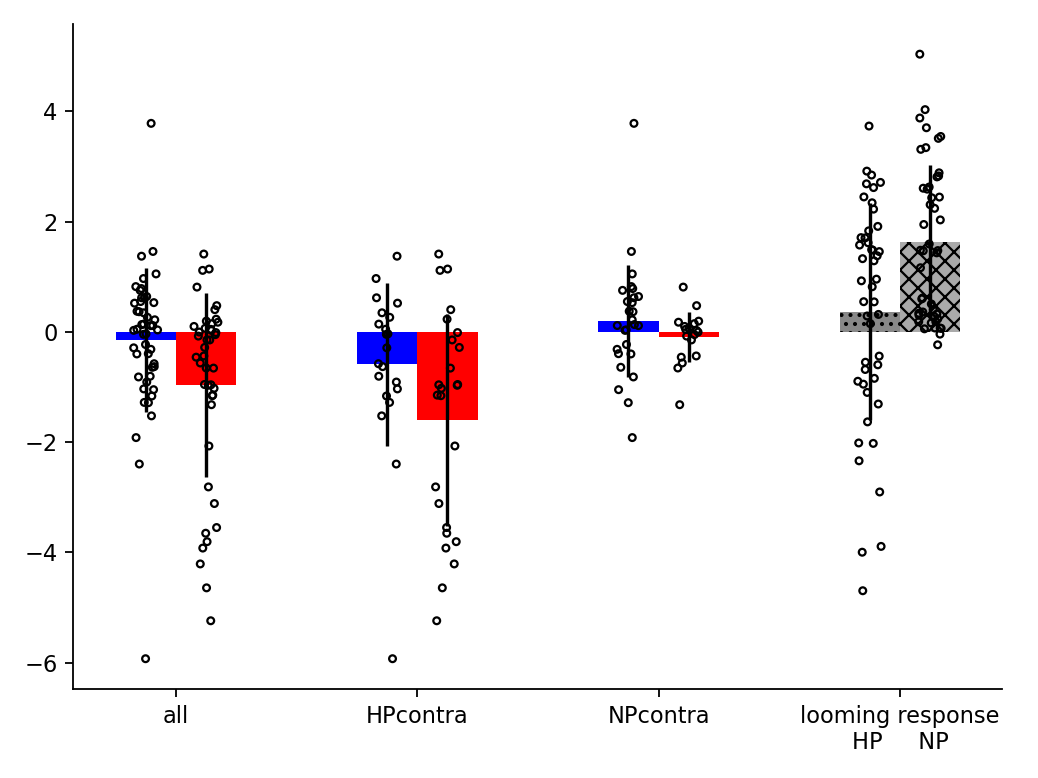

In [143]:
f,ax=plt.subplots()

barheights = [ np.nanmean(np.concatenate((strg_hyp,strg_nop))),
               np.nanmean(np.concatenate((sacc_hyp,sacc_nop))), 
               np.nanmean(strg_hyp),
               np.nanmean(sacc_hyp),
               np.nanmean(strg_nop),
               np.nanmean(sacc_nop),
               np.nanmean(np.concatenate((beforesacc_hyp,beforestrg_hyp))),
               np.nanmean(np.concatenate((beforesacc_nop,beforestrg_nop))) ]
barerr = [ np.nanstd(np.concatenate((strg_hyp,strg_nop))),
               np.nanstd(np.concatenate((sacc_hyp,sacc_nop))), 
               np.nanstd(strg_hyp),
               np.nanstd(sacc_hyp),
               np.nanstd(strg_nop),
               np.nanstd(sacc_nop),
               np.nanstd(np.concatenate((beforesacc_hyp,beforestrg_hyp))),
               np.nanstd(np.concatenate((beforesacc_nop,beforestrg_nop))) ]
# barheights = [ np.nanmedian(np.concatenate((strg_hyp,strg_nop))),
#                np.nanmedian(np.concatenate((sacc_hyp,sacc_nop))), 
#                np.nanmedian(strg_hyp),
#                np.nanmedian(sacc_hyp),
#                np.nanmedian(strg_nop),
#                np.nanmedian(sacc_nop) ]
# barerr = np.array([ np.nanpercentile(np.concatenate((strg_hyp,strg_nop)), (0.25,0.75)),
#                np.nanpercentile(np.concatenate((sacc_hyp,sacc_nop)), (0.25,0.75)), 
#                np.nanpercentile(strg_hyp, (0.25,0.75)),
#                np.nanpercentile(sacc_hyp, (0.25,0.75)),
#                np.nanpercentile(strg_nop, (0.25,0.75)),
#                np.nanpercentile(sacc_nop, (0.25,0.75)) ]).T

barwidth=0.1
xpos = np.array([-0.5,0.5,3.5,4.5,7.5,8.5, 11.5,12.5]) * barwidth
# ax.bar([0-barwidth/2, 0+barwidth/2, 1-barwidth/2, 1+barwidth/2, 2-barwidth/2, 2+barwidth/2], barheights,
#        width=barwidth, color=['b','r','b','r','b','r'])
ax.bar(xpos, barheights,width=barwidth, color=['b','r','b','r','b','r', '#888888', '#aaaaaa'], yerr=barerr)
# ax.scatter([0-barwidth/2]*(len(strg_hyp)+len(strg_nop)), np.concatenate((strg_hyp,strg_nop)), color='k',marker='x' )
# ax.scatter([0+barwidth/2]*(len(sacc_hyp)+len(sacc_nop)), np.concatenate((sacc_hyp,sacc_nop)), color='k',marker='x' )
# ax.scatter([1-barwidth/2]*len(strg_hyp), strg_hyp, color='k',marker='x')
# ax.scatter([1+barwidth/2]*len(sacc_hyp), sacc_hyp, color='k',marker='x')
# ax.scatter([2-barwidth/2]*len(strg_nop), strg_nop, color='k',marker='x')
# ax.scatter([2+barwidth/2]*len(sacc_nop), sacc_nop, color='k',marker='x')
ax.scatter(np.array([xpos[0]]*(len(strg_hyp)+len(strg_nop)))+np.random.random_sample(len(strg_hyp)+len(strg_nop))*barwidth/2.5-barwidth/5, 
           np.concatenate((strg_hyp,strg_nop)), color='k',marker='.' , facecolor='None')
ax.scatter(np.array([xpos[1]]*(len(sacc_hyp)+len(sacc_nop)))+np.random.random_sample(len(sacc_hyp)+len(sacc_nop))*barwidth/2.5-barwidth/5, 
           np.concatenate((sacc_hyp,sacc_nop)), color='k',marker='.' , facecolor='None')
ax.scatter(np.array([xpos[2]]*len(strg_hyp))+np.random.random_sample(len(strg_hyp))*barwidth/2.5-barwidth/5,
           strg_hyp, color='k',marker='.', facecolor='None')
ax.scatter(np.array([xpos[3]]*len(sacc_hyp))+np.random.random_sample(len(sacc_hyp))*barwidth/2.5-barwidth/5,
           sacc_hyp, color='k',marker='.', facecolor='None')
ax.scatter(np.array([xpos[4]]*len(strg_nop))+np.random.random_sample(len(strg_nop))*barwidth/2.5-barwidth/5,
           strg_nop, color='k',marker='.', facecolor='None')
ax.scatter(np.array([xpos[5]]*len(sacc_nop))+np.random.random_sample(len(sacc_nop))*barwidth/2.5-barwidth/5,
           sacc_nop, color='k',marker='.', facecolor='None')

ax.scatter(np.array([xpos[6]]*(len(beforestrg_hyp)+len(beforesacc_hyp)))+np.random.random_sample(len(beforestrg_hyp)+len(beforesacc_hyp))*barwidth/2.5-barwidth/5,
           np.concatenate((beforestrg_hyp, beforesacc_hyp)), color='k',marker='.', facecolor='None')
ax.scatter(np.array([xpos[7]]*(len(beforestrg_nop)+len(beforesacc_nop)))+np.random.random_sample(len(beforestrg_nop)+len(beforesacc_nop))*barwidth/2.5-barwidth/5,
           np.concatenate((beforestrg_nop, beforesacc_nop)), color='k',marker='.', facecolor='None')
# ax.scatter(np.array([xpos[6]]*(len(beforesacc_hyp)))+np.random.random_sample(len(beforesacc_hyp))*barwidth/2.5-barwidth/5,
#            np.concatenate((beforesacc_hyp, )), color='k',marker='.', facecolor='None')
# ax.scatter(np.array([xpos[7]]*(len(beforesacc_nop)))+np.random.random_sample(len(beforesacc_nop))*barwidth/2.5-barwidth/5,
#            np.concatenate((beforesacc_nop, )), color='k',marker='.', facecolor='None')


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks((xpos[0:8:2]+xpos[1:8:2])/2)
ax.set_xticklabels(['all','HPcontra','NPcontra', 'looming response\nHP     NP'])#, 'looming response\nNP'])

ax.get_children()[7].set_hatch('xxx')
ax.get_children()[6].set_hatch('...')
plt.tight_layout()

<IPython.core.display.Javascript object>


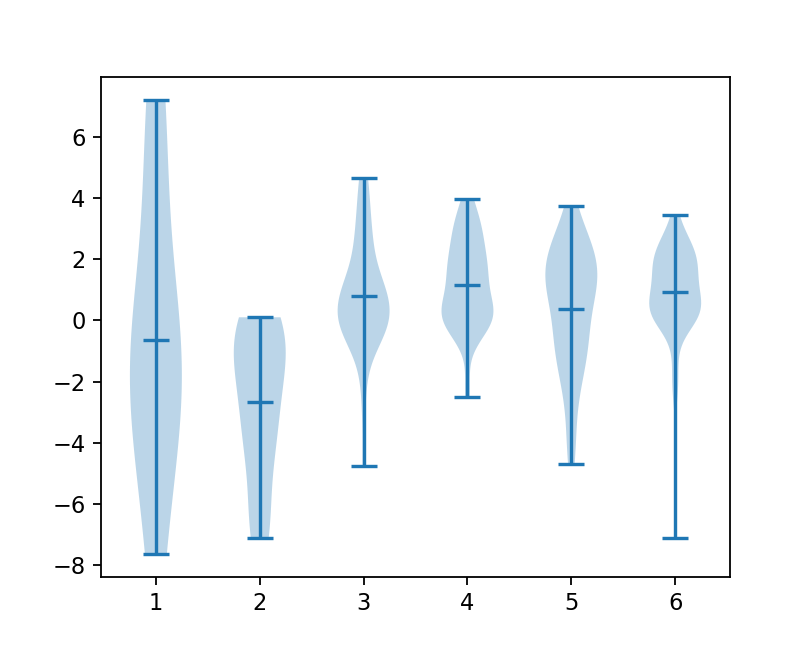

In [545]:
f,ax=plt.subplots(figsize=(5,4))
bef_ = np.concatenate((beforestrg_hyp, beforesacc_hyp))
bef_hyp = bef_hyp[~np.isnan(bef_hyp)]
bef_nop = np.concatenate((beforestrg_nop, beforesacc_nop))
bef_nop = bef_nop[~np.isnan(bef_nop)]
ax.violinplot((strg_hyp[~np.isnan(strg_hyp)], sacc_hyp[~np.isnan(sacc_hyp)], strg_nop[~np.isnan(strg_nop)], sacc_nop[~np.isnan(sacc_nop)], bef_hyp,bef_nop),
              showmeans=True, )
print()

## statistical testing

The two-sided test has the null hypothesis that the median of the differences is zero against the alternative that it is different from zero. The one-sided test has the null hypothesis that the median is positive (i.e. 𝑦<𝑥 as 𝐻0) against the alternative that it is negative (alternative == 'less'), or vice versa (alternative == 'greater.', i.e. 𝑦>𝑥 ).

Thus, if we expect y to be larger than x, set alternative == 'less') [calling wilcoxon(x,y,...)]

In [132]:
# Shapiro Wilks tests for normality followed by paired t-test 
# testVar
# stats.shapiro(np.array(strg_hyp)-np.array(sacc_hyp)),
print(stats.shapiro(np.array(strg_hyp)[~np.isnan(strg_hyp)]))
print(stats.shapiro(np.array(sacc_hyp)[~np.isnan(sacc_hyp)]))

print(stats.ttest_1samp(np.array(strg_hyp)[~np.isnan(strg_hyp)], 0))
print(stats.ttest_1samp(np.array(sacc_hyp)[~np.isnan(sacc_hyp)], 0))

print(stats.ttest_1samp(np.concatenate((np.array(strg_hyp)[~np.isnan(strg_hyp)],np.array(strg_nop)[~np.isnan(strg_nop)])) , 0))
print(stats.ttest_1samp(np.concatenate((np.array(sacc_hyp)[~np.isnan(sacc_hyp)],np.array(sacc_nop)[~np.isnan(sacc_nop)])) , 0))

# print(stats.ttest_rel(np.array(strg_hyp)[~np.isnan(strg_hyp)], np.array(sacc_hyp)[~np.isnan(sacc_hyp)], alternative='greater'))

ShapiroResult(statistic=0.9430689215660095, pvalue=0.6415054798126221)
ShapiroResult(statistic=0.9126455783843994, pvalue=0.04645112529397011)
Ttest_1sampResult(statistic=-0.31927096921144993, pvalue=0.7588377756466061)
Ttest_1sampResult(statistic=-5.128225354568879, pvalue=3.86429047097579e-05)
Ttest_1sampResult(statistic=1.710147030849116, pvalue=0.09319985338965948)
Ttest_1sampResult(statistic=0.12063207234317268, pvalue=0.9043138776881634)


In [133]:
print(stats.ttest_ind(np.array(strg_hyp)[~np.isnan(strg_hyp)], np.array(sacc_hyp)[~np.isnan(sacc_hyp)], alternative='greater'))
print(stats.ttest_ind(np.array(strg_nop)[~np.isnan(strg_nop)], np.array(sacc_nop)[~np.isnan(sacc_nop)], alternative='greater'))

Ttest_indResult(statistic=1.6214699517177038, pvalue=0.05787032959765703)
Ttest_indResult(statistic=-1.2565725175814695, pvalue=0.893988905960764)


In [134]:
print(stats.mannwhitneyu(np.array(strg_hyp)[~np.isnan(strg_hyp)], np.array(sacc_hyp)[~np.isnan(sacc_hyp)],
                         alternative='greater', method='exact'))
print(stats.mannwhitneyu(np.array(strg_nop)[~np.isnan(strg_nop)], np.array(sacc_nop)[~np.isnan(sacc_nop)],
                         alternative='greater', method='exact'))

# testvar1 = np.concatenate((np.array(strg_hyp)[~np.isnan(strg_hyp)], np.array(strg_nop)[~np.isnan(strg_nop)]))
# testvar2 = np.concatenate((np.array(sacc_hyp)[~np.isnan(sacc_hyp)], np.array(sacc_nop)[~np.isnan(sacc_nop)]))
# print(stats.mannwhitneyu(testvar1, testvar2, alternative='greater'))
# print(stats.mannwhitneyu(testvar1, testvar2, alternative='two-sided'))

MannwhitneyuResult(statistic=111.0, pvalue=0.2056332297044199)
MannwhitneyuResult(statistic=931.0, pvalue=0.9443110229253202)


In [135]:
# ranksum test for confirmation, should be pretty close to MannWhitneyU
print(stats.ranksums(np.array(strg_hyp)[~np.isnan(strg_hyp)], np.array(sacc_hyp)[~np.isnan(sacc_hyp)], alternative='greater'))
print(stats.ranksums(np.array(strg_nop)[~np.isnan(strg_nop)], np.array(sacc_nop)[~np.isnan(sacc_nop)], alternative='greater'))

# testvar1 = np.concatenate((np.array(strg_hyp)[~np.isnan(strg_hyp)], np.array(strg_nop)[~np.isnan(strg_nop)]))
# testvar2 = np.concatenate((np.array(sacc_hyp)[~np.isnan(sacc_hyp)], np.array(sacc_nop)[~np.isnan(sacc_nop)]))
# print(stats.ranksums(testvar1, testvar2, alternative='greater'))

RanksumsResult(statistic=0.8577492032361055, pvalue=0.19551548218507914)
RanksumsResult(statistic=-1.5895394526247881, pvalue=0.9440306728467379)


In [136]:
print(stats.wilcoxon(np.array(strg_hyp)[~np.isnan(strg_hyp)]))
print(stats.wilcoxon(np.array(sacc_hyp)[~np.isnan(sacc_hyp)]))
print(stats.wilcoxon(np.array(strg_nop)[~np.isnan(strg_nop)]))
print(stats.wilcoxon(np.array(sacc_nop)[~np.isnan(sacc_nop)]))
# print(stats.wilcoxon(np.concatenate((np.array(strg_hyp)[~np.isnan(strg_hyp)], np.array(strg_nop)[~np.isnan(strg_nop)]))))
# print(stats.wilcoxon(np.concatenate((np.array(sacc_hyp)[~np.isnan(sacc_hyp)], np.array(sacc_nop)[~np.isnan(sacc_nop)]))))
# print(stats.ranksums(np.array(strg_nop)[~np.isnan(strg_nop)], np.array(sacc_nop)[~np.isnan(sacc_nop)], alternative='greater'))


WilcoxonResult(statistic=13.0, pvalue=0.546875)
WilcoxonResult(statistic=10.0, pvalue=1.0251998901367188e-05)
WilcoxonResult(statistic=260.0, pvalue=0.003654448460960415)
WilcoxonResult(statistic=148.0, pvalue=1.383719454843149e-06)


In [137]:
print(stats.wilcoxon(np.array(strg_hyp)[~np.isnan(strg_hyp)], alternative='less'))
print(stats.wilcoxon(np.array(sacc_hyp)[~np.isnan(sacc_hyp)], alternative='less'))
print(stats.wilcoxon(np.array(strg_nop)[~np.isnan(strg_nop)], alternative='less'))
print(stats.wilcoxon(np.array(sacc_nop)[~np.isnan(sacc_nop)], alternative='less'))
# print(stats.wilcoxon(np.concatenate((np.array(strg_hyp)[~np.isnan(strg_hyp)], np.array(strg_nop)[~np.isnan(strg_nop)]))))
# print(stats.wilcoxon(np.concatenate((np.array(sacc_hyp)[~np.isnan(sacc_hyp)], np.array(sacc_nop)[~np.isnan(sacc_nop)]))))
# print(stats.ranksums(np.array(strg_nop)[~np.isnan(strg_nop)], np.array(sacc_nop)[~np.isnan(sacc_nop)], alternative='greater'))


WilcoxonResult(statistic=13.0, pvalue=0.2734375)
WilcoxonResult(statistic=10.0, pvalue=5.125999450683594e-06)
WilcoxonResult(statistic=775.0, pvalue=0.9981727757695198)
WilcoxonResult(statistic=1178.0, pvalue=0.9999993081402726)


In [144]:
# statistics about looming response amplitude
bef_hyp = np.concatenate((np.array(beforesacc_hyp)[~np.isnan(beforesacc_hyp)],np.array(beforestrg_hyp)[~np.isnan(beforestrg_hyp)]))
print(stats.wilcoxon( bef_hyp))
bef_nop = np.concatenate((np.array(beforesacc_nop)[~np.isnan(beforesacc_nop)],np.array(beforestrg_nop)[~np.isnan(beforestrg_nop)]))
print(stats.wilcoxon(bef_nop))

print(stats.mannwhitneyu(bef_hyp, bef_nop))

WilcoxonResult(statistic=398.0, pvalue=0.11950236133279273)
WilcoxonResult(statistic=10.0, pvalue=1.0136288155102125e-08)
MannwhitneyuResult(statistic=701.0, pvalue=0.00811311726556578)


# simple Vm plots of hyperpolarization saccades Y/N
Need to either calculate using method above or load the pickled results. But first make sure that this method is valid, in the sense that it measures the Vm in the correct time window.

## analyze straight
Whether we form the saSacc/Rest_all from the spont or contra groups does not matter, since all we want to do is analyze all of them and store in a dict for each fly separately

Actually calculates these values the same way as in section 5, but redo here in a trial-wise fashion

In [13]:
saStrg_all = copy.deepcopy(saStrg_Rhyp)
saStrg_all+saStrg_Rnop

C:\Users\Phil\Documents\notebooks\baseClasses.py:256: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  selector = allValues.between(start-0.05, start+tolerance, inclusive=True)#inclusive=True is default


In [75]:
anlyz = saStrg_all
allfliesBAK = copy.deepcopy(anlyz)

In [76]:
# trial-wise version

slopeDict = {}

for flyNo, flyid in list(allfliesBAK.flyID.items()):
    print(flyNo,flyid)
    thisFly = copy.copy(allfliesBAK)
    thisFly.remove_duds_byList(np.nonzero(thisFly.fly_indices!=flyNo))
    thisFly.average_by_stimSignal()

    # iterate through stims for which to calculate
    results = {}
    for stimID in set(thisFly.group_indices):
        d = thisFly.get_by_group(stimID)
        results[stimID] = np.zeros((d.shape[0],3))
        for i in range(d.shape[0]):
            # average level
            start = int((anlyz.preStim+ anlyz.meanFramePeriod*(anlyz.stimulusPhases_inframes[1]+sample_endLoom))*anlyz.samplingRate)
            stop = int((anlyz.preStim+ anlyz.meanFramePeriod*(anlyz.stimulusPhases_inframes[1]+sample_optomotor))*anlyz.samplingRate)
            meanAmpl = np.mean(100.*d[i,0, stop-80:stop+80])
            startVal = np.mean(100.*d[i,0, start-0:start+int(avgWindow_endLoom*anlyz.samplingRate)])
            before = np.mean(100.*d[i,0, start-int(0.2*anlyz.samplingRate):start])
            results[stimID][i] = [meanAmpl, startVal, before]
    slopeDict[flyid.lower()] = results


0

	 fly1_WTCS_20180725_cell1
1

	 fly4_X21_20200420_cell1
2

	 fly1_u29xg06_20190213_cell1
3

	 fly1_WTCS_20190726_cell1
4

	 fly3_U29xG16_20200129_cell1
5

	 fly1_X20a_20200316_cell1
6

	 fly1_G06xU29_20191104_cell1
7

	 fly1_U29xG16_20191209_cell2
8

	 fly3_X21_20200415_cell1
9

	 fly3_x21_20200417_cell1
10

	 fly2_X20_20210217_cell1
11

	 fly1_WTCS_20191106_cell1
12

	 fly1_U29xG16_20200129_cell1


In [77]:
straightSlopeDict = slopeDict

In [78]:
plt.close('all')

## analyse saccades

In [18]:
saSacc_all = copy.deepcopy(saSacc_Rhyp)
saSacc_all+saSacc_Rnop

In [80]:
anlyz = saSacc_all
allfliesBAK = copy.deepcopy(anlyz)

In [76]:
# trial-wise version

slopeDict = {}

for flyNo, flyid in list(allfliesBAK.flyID.items()):
    print(flyNo,flyid)
    thisFly = copy.copy(allfliesBAK)
    thisFly.remove_duds_byList(np.nonzero(thisFly.fly_indices!=flyNo))
    thisFly.average_by_stimSignal()

    # iterate through stims for which to calculate
    results = {}
    for stimID in set(thisFly.group_indices):
        d = thisFly.get_by_group(stimID)
        results[stimID] = np.zeros((d.shape[0],3))
        for i in range(d.shape[0]):
            # average level
            start = int((anlyz.preStim+ anlyz.meanFramePeriod*(anlyz.stimulusPhases_inframes[1]+sample_endLoom))*anlyz.samplingRate)
            stop = int((anlyz.preStim+ anlyz.meanFramePeriod*(anlyz.stimulusPhases_inframes[1]+sample_optomotor))*anlyz.samplingRate)
            meanAmpl = np.mean(100.*d[i,0, stop-80:stop+80])
            startVal = np.mean(100.*d[i,0, start-0:start+int(avgWindow_endLoom*anlyz.samplingRate)])
            before = np.mean(100.*d[i,0, start-int(0.2*anlyz.samplingRate):start])
            results[stimID][i] = [meanAmpl, startVal, before]
    slopeDict[flyid.lower()] = results


0

	 fly1_WTCS_20180725_cell1
1

	 fly4_X21_20200420_cell1
2

	 fly1_u29xg06_20190213_cell1
3

	 fly1_WTCS_20190726_cell1
4

	 fly3_U29xG16_20200129_cell1
5

	 fly1_X20a_20200316_cell1
6

	 fly1_G06xU29_20191104_cell1
7

	 fly1_U29xG16_20191209_cell2
8

	 fly3_X21_20200415_cell1
9

	 fly3_x21_20200417_cell1
10

	 fly2_X20_20210217_cell1
11

	 fly1_WTCS_20191106_cell1
12

	 fly1_U29xG16_20200129_cell1


In [77]:
straightSlopeDict = slopeDict

In [78]:
plt.close('all')

## save/load results

In [40]:
with open(os.path.join(DATAPATH, 'Figures4Paper',
      'inhibitionQuantified_saccadesVsStraight_loomWindowAt1.5frames_optomotWindowAt4.5_allTrials_incLoomResp.pickle'),
          'rb') as fl:
    allvar=pickle.load(fl)
    straightSlopeDict, saccadeSlopeDict = allvar['restingSlopeDict'], allvar['saccadeSlopeDict']

##  plots

In [139]:
# hypolFlies = [v.lower() for _,v in saSacc_Rhyp.flyID.items()]
# nopolFlies = [v.lower() for _,v in saSacc_Rnop.flyID.items()]

hypolFlies = [v.lower() for _,v in saSacc_Lhyp.flyID.items()]
nopolFlies = [v.lower() for _,v in saRest_Lnop.flyID.items()]

In [140]:
hypolFlies, nopolFlies

(['fly1_wtcs_20180725_cell1',
  'fly4_x21_20200420_cell1',
  'fly1_u29xg06_20190213_cell1',
  'fly1_wtcs_20190726_cell1',
  'fly3_u29xg16_20200129_cell1',
  'fly1_x20a_20200316_cell1'],
 ['fly1_g06xu29_20191104_cell1',
  'fly1_u29xg16_20191209_cell2',
  'fly3_x21_20200415_cell1',
  'fly3_x21_20200417_cell1',
  'fly2_x20_20210217_cell1'])

In [141]:
# assessing if keys are sorted...
print(len([fid for fid,r in saccadeSlopeDict.items() if fid.lower() in hypolFlies])==len(hypolFlies))
print(len([fid for fid,r in saccadeSlopeDict.items() if fid.lower() in nopolFlies])==len(nopolFlies))

print([fid for fid,r in straightSlopeDict.items() if fid.lower() in hypolFlies])
print([fid for fid,r in saccadeSlopeDict.items() if fid.lower() in hypolFlies])

['fly1_wtcs_20180725_cell1', 'fly4_x21_20200420_cell1', 'fly1_u29xg06_20190213_cell1', 'fly1_wtcs_20190726_cell1', 'fly3_u29xg16_20200129_cell1', 'fly1_x20a_20200316_cell1']
['fly1_wtcs_20180725_cell1', 'fly4_x21_20200420_cell1', 'fly1_u29xg06_20190213_cell1', 'fly1_wtcs_20190726_cell1', 'fly3_u29xg16_20200129_cell1', 'fly1_x20a_20200316_cell1']


# Playground

## plot loom L rot CLW vs rot CLW

<IPython.core.display.Javascript object>


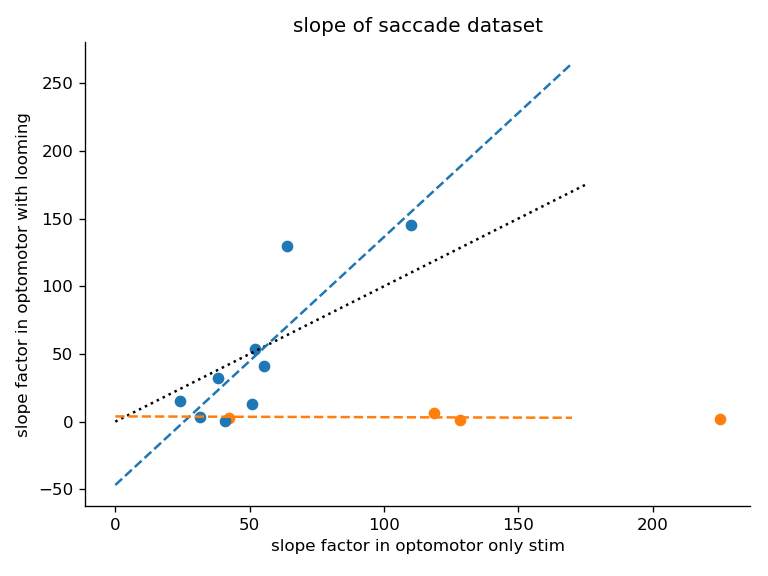

In [123]:
f,ax=plt.subplots(1,1)
hypolFlies = [v for _,v in saRest_Rhyp.flyID.items()]
ax.scatter([r[6][0] for fid,r in slopeDict.items() if fid in hypolFlies],
           [r[0][0] for fid,r in slopeDict.items() if fid in hypolFlies], 
           label=[fid for fid,r in slopeDict.items() if fid in hypolFlies], color='tab:orange')
# ax.scatter([r[6][0] for fid,r in slopeDict.items()], [r[7][0] for fid,r in slopeDict.items()], label=[fid for fid,r in slopeDict.items()])
nopolFlies = [v for _,v in saRest_Rnop.flyID.items()]
ax.scatter([r[6][0] for fid,r in slopeDict.items() if fid in nopolFlies],
           [r[0][0] for fid,r in slopeDict.items() if fid in nopolFlies], 
           label=[fid for fid,r in slopeDict.items() if fid in nopolFlies], color='tab:blue')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('slope factor in optomotor only stim')
ax.set_ylabel('slope factor in optomotor with looming')
# ax.plot([0,0.007],[0,0.007],'--k')
ax.plot([0,175],[0,175],':k')
plt.tight_layout()

In [124]:
lr_nopol = stats.linregress([r[6][0] for fid,r in slopeDict.items() if fid in nopolFlies],
                 [r[0][0] for fid,r in slopeDict.items() if fid in nopolFlies])
lr_hypol = stats.linregress([r[6][0] for fid,r in slopeDict.items() if fid in hypolFlies],
                 [r[0][0] for fid,r in slopeDict.items() if fid in hypolFlies])
lr_all = stats.linregress([r[6][0] for fid,r in slopeDict.items()],
                 [r[0][0] for fid,r in slopeDict.items()] )
ax.plot([0,170], np.array([0,170])*lr_nopol.slope+lr_nopol.intercept, '--',color='tab:blue')
ax.plot([0,170], np.array([0,170])*lr_hypol.slope+lr_hypol.intercept, '--',color='tab:orange')
# ax.plot([0,170], np.array([0,170])*lr_all.slope+lr_all.intercept, 'k--')

print('Nopol\n',lr_nopol)
print('Hypol\n',lr_hypol)
print('all\n',lr_all)

Nopol
 LinregressResult(slope=1.8320726545530008, intercept=-46.830984881946726, rvalue=0.8561123853576993, pvalue=0.0032229098353572846, stderr=0.41800043457144254, intercept_stderr=23.822318694616673)
Hypol
 LinregressResult(slope=-0.005951523951446923, intercept=3.855394902333969, rvalue=-0.17957898098362945, pvalue=0.8204210190163705, stderr=0.023053644236441087, intercept_stderr=3.320237779893951)
all
 LinregressResult(slope=-0.011985927612051903, intercept=35.20314434011104, rvalue=-0.01382580916975992, pvalue=0.9642442757609057, stderr=0.2613624769579568, intercept_stderr=24.281246201910573)


In [120]:
hypolFlies = [v for _,v in saRest_Rhyp.flyID.items()]
# px.scatter( [r[6][0] for fid,r in slopeDict.items() if fid in nopolFlies],
#            [r[0][0] for fid,r in slopeDict.items() if fid in nopolFlies], 
#            label=[fid for fid,r in slopeDict.items() if fid in nopolFlies] )
px.scatter( x=[r[6][0] for fid,r in slopeDict.items()],
           y=[r[0][0] for fid,r in slopeDict.items()],
           labels={'x':'slope factor in optomotor only stim', 'y':'slope factor in optomotor with looming'},
#            label=[fid for fid,r in slopeDict.items()],
           color=[int(v in hypolFlies) for v in slopeDict],
           text=list(slopeDict.keys())
          )

## define onset more precisely

In [60]:
flyNo = 1
flyid = saFly_Rnop.flyID[flyNo]

print('\n\t',flyid)
thisFly = copy.deepcopy(saFly_Rnop)
thisFly.remove_duds_byList(np.nonzero(thisFly.fly_indices!=flyNo))
thisFly.average_by_stimSignal()

#define onset of rising slope



	 fly1_X20a_20200316_cell1


In [21]:
thisFly.flyID, set(thisFly.fly_indices), flyid, stimID
flyid='fly1_X20a_20200316_cell1', flyid=5

({0: 'fly1_WTCS_20180725_cell1',
  1: 'fly1_WTCS_20190213_cell1',
  2: 'fly1_WTCS_20190726_cell1',
  3: 'fly4_X21_20200420_cell1',
  4: 'fly3_U29xG16_20200129_cell1',
  5: 'fly1_X20a_20200316_cell1',
  6: 'fly1_WTCS_20191106_cell1',
  7: 'fly1_U29xG16_20200129_cell1',
  8: 'fly1_G06xU29_20191104_cell1',
  9: 'fly1_U29xG16_20191209_cell2',
  10: 'fly3_X21_20200415_cell1',
  11: 'fly3_x21_20200417_cell1',
  12: 'fly2_X20_20210217_cell1'},
 {9},
 'fly1_U29xG16_20191209_cell2',
 6)

In [32]:
stimID=0

<IPython.core.display.Javascript object>


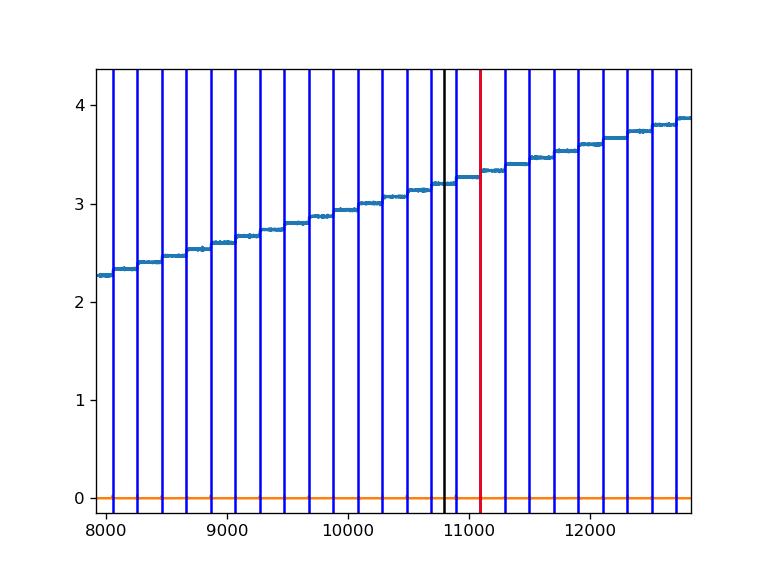

In [38]:
f,ax=plt.subplots(1,1)
d=thisFly.get_avg_data('arenaOut')
ax.plot(d[stimID])
detectSignal = np.diff(signal.medfilt(d[6],101))
ax.plot(detectSignal)

steps = signal.find_peaks(detectSignal, height=0.004, distance=150)[0]
[ax.axvline(x, color='b') for x in steps]
#start = int((thisFly.preStim+(thisFly.stimulusPhases_inframes[1]+1.)*thisFly.meanFramePeriod)*thisFly.samplingRate)
start = steps[(thisFly.stimulusPhases_inframes[1])]+int(thisFly.meanFramePeriod/2*thisFly.samplingRate)
#stop = steps[(thisFly.stimulusPhases_inframes[1]+9)]
stop = steps[(thisFly.stimulusPhases_inframes[1]+2)]
ax.axvline(start, color='k')
ax.axvline(stop, color='r')